# Sleep Stages Classification - Exploratory Data Analysis

This notebook presents an exploratory analysis of sleep stage classification data, organizing the findings narratively to tell the story of the data.

## Data Context

The data comes from the Sleep-EDF dataset, where each row represents a 30-second epoch of polysomnographic (PSG) recording. PSG is the gold standard sleep test, recording physiological signals such as EEG, EOG, EMG, respiration, and temperature.

### Sleep Stages
- **W**: Wake
- **N1**: Stage 1 NREM sleep (transition)
- **N2**: Stage 2 NREM sleep (light sleep)
- **N3**: Stage 3 NREM sleep (deep sleep)
- **REM**: REM (Rapid Eye Movement) sleep

---

## 1. Data Configuration and Loading

In [18]:
import polars as pl
pl.Config.set_fmt_str_lengths(100)

import pandas as pd
import polars.selectors as cs
import numpy as np
import itertools
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import rankdata, spearmanr, kruskal
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression
from IPython.display import display, Markdown

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [19]:
file_source = Path().resolve().parents[2] / "datalake" / "processed" / "sleep-telemetry" / "subject_id=ST704" / "ST704N1.parquet"
df = pl.read_parquet(file_source)

print(f"Loaded dataset: {df.height:,} epochs × {df.width} features")
print(f"Total period: {df.height * 30 / 3600:.1f} hours of recording")
display(df.head())

Loaded dataset: 1,007 epochs × 274 features
Total period: 8.4 hours of recording


subject_id,night_id,age,sex,tso_min,epoch_idx,t0_sec,stage,EMG_submental_mean_1hz,EMG_submental_std_1hz,EMG_submental_min_1hz,EMG_submental_max_1hz,EMG_submental_rms_1hz,EMG_submental_slope_1hz,EMG_submental_median_1hz,EMG_submental_iqr_1hz,EMG_submental_mad_1hz,EMG_submental_p01_1hz,EMG_submental_p10_1hz,EMG_submental_p90_1hz,EMG_submental_p99_1hz,EMG_submental_kurtosis_1hz,EMG_submental_skewness_1hz,EMG_submental_diff_rms_1hz,EMG_submental_zcr_1hz,EEG_Fpz_Cz_delta_pow_256,EEG_Fpz_Cz_delta_relpow_256,EEG_Fpz_Cz_delta_logpow_256,EEG_Fpz_Cz_delta_peakfreq_256,EEG_Fpz_Cz_theta_pow_256,EEG_Fpz_Cz_theta_relpow_256,EEG_Fpz_Cz_theta_logpow_256,EEG_Fpz_Cz_theta_peakfreq_256,EEG_Fpz_Cz_alpha_pow_256,EEG_Fpz_Cz_alpha_relpow_256,EEG_Fpz_Cz_alpha_logpow_256,EEG_Fpz_Cz_alpha_peakfreq_256,…,EMG_submental_alpha_logpow_512,EMG_submental_alpha_peakfreq_512,EMG_submental_sigma_pow_512,EMG_submental_sigma_relpow_512,EMG_submental_sigma_logpow_512,EMG_submental_sigma_peakfreq_512,EMG_submental_beta_pow_512,EMG_submental_beta_relpow_512,EMG_submental_beta_logpow_512,EMG_submental_beta_peakfreq_512,EMG_submental_delta_theta_ratio_512,EMG_submental_theta_alpha_ratio_512,EMG_submental_alpha_sigma_ratio_512,EMG_submental_slow_fast_ratio_512,EMG_submental_sef95_512,EMG_submental_medfreq_512,EMG_submental_spec_entropy_512,EMG_submental_aperiodic_slope_512,EMG_submental_rms,EMG_submental_var,Event_marker_mean_10hz,Event_marker_std_10hz,Event_marker_min_10hz,Event_marker_max_10hz,Event_marker_rms_10hz,Event_marker_slope_10hz,Event_marker_median_10hz,Event_marker_iqr_10hz,Event_marker_mad_10hz,Event_marker_p01_10hz,Event_marker_p10_10hz,Event_marker_p90_10hz,Event_marker_p99_10hz,Event_marker_kurtosis_10hz,Event_marker_skewness_10hz,Event_marker_diff_rms_10hz,Event_marker_zcr_10hz
str,str,i64,str,f64,i64,f64,enum,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""ST704""","""N1""",18,"""M""",0.0,25,750.0,"""N1""",791.434496,262.839731,87.837274,901.314043,833.938418,-27.521929,894.158569,0.0,0.0,90.211024,158.41153,894.158569,899.238956,3.445246,-2.280828,138.093531,0.0,2455.896173,0.766613,3.39021,0.78125,252.484856,0.078814,2.402235,4.296875,123.144747,0.03844,2.090416,8.203125,…,1.818455,8.0078125,25.717195,0.008743,1.410224,14.257812,50.581499,0.017196,1.703992,27.148438,9.844986,3.920756,2.559948,24.045854,7.8125,0.9765625,0.578764,-2.160838,284.613708,81004.96875,-26.733333,10.877908,-31.0,1.0,28.861739,1.070234,-31.0,0.0,0.0,-31.0,-31.0,1.0,1.0,2.718883,2.168133,1.850608,0.003344
"""ST704""","""N1""",18,"""M""",0.5,26,780.0,"""N1""",136.243648,87.815113,34.937254,504.305861,162.092028,1.076212,110.348869,59.275886,32.930206,36.089968,57.927916,217.911255,429.453577,9.358024,2.571825,114.410178,0.0,3039.316449,0.906694,3.482776,0.78125,250.77269,0.074811,2.39928,4.296875,27.774841,0.008286,1.443652,9.375,…,3.23827,9.5703125,545.949227,0.055024,2.737152,12.304688,2102.943314,0.211946,3.322828,25.976562,1.336251,1.370561,3.170426,1.44562,26.757812,7.03125,0.927799,-0.778602,139.910934,19575.068359,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN,NaN,0.0,0.0
"""ST704""","""N1""",18,"""M""",1.0,27,810.0,"""N1""",171.02056,186.794771,16.059278,915.28626,253.25939,0.087191,121.675637,73.552227,41.511079,16.581091,34.247726,382.617189,826.42828,8.208486,2.735358,266.360839,0.0,1885.659391,0.883868,3.275463,0.78125,201.907951,0.094641,2.305153,4.296875,22.915579,0.010741,1.360131,8.203125,…,3.669113,10.742188,4112.044859,0.102823,3.614058,15.039062,7126.539908,0.178202,3.852879,26.171875,1.95789,1.744422,1.135156,2.042081,25.390625,5.46875,0.900101,-1.14877,236.693497,56023.8125,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,NaN,NaN,0.0,0.0
"""ST704""","""N1""",18,"""M""",1.5,28,840.0,"""N1""",177.931605,102.867933,38.003918,397.71

## 2. Data Overview

### 2.1 Data Structure and Quality

In [20]:
print("=== DATA STRUCTURE ===")
print(f"Dimensions: {df.height:,} epochs × {df.width} features")
print(f"Period: {df.height * 30 / 60:.0f} minutes ({df.height * 30 / 3600:.1f} hours)")

column_types = pl.Series("Dtypes", df.dtypes)
print("\n=== DATA TYPES ===")
display(column_types.value_counts())

null_counts = df.null_count()
total_nulls = null_counts.select(pl.sum_horizontal(pl.all())).item()
print(f"\n=== DATA QUALITY ===")
print(f"Total null values: {total_nulls:,}")
print("Full dataset - no missing values!")

=== DATA STRUCTURE ===
Dimensions: 1,007 epochs × 274 features
Period: 504 minutes (8.4 hours)

=== DATA TYPES ===


Dtypes,count
object,u32
"Enum(categories=['W', 'N1', 'N2', 'N3', 'REM'])",1
String,3
Float64,268
Int64,2



=== DATA QUALITY ===
Total null values: 0
Full dataset - no missing values!


### 2.2 Feature Categorization

Features are organized into different physiological categories:

In [21]:
columns = df.columns

feature_categories = {
    'Identification': ['subject_id', 'night_id', 'epoch_idx', 't0_sec', 'tso_min'],
    'Target': ['stage'],
    'EEG (Fpz-Cz)': [col for col in columns if 'EEG_Fpz_Cz' in col],
    'EEG (Pz-Oz)': [col for col in columns if 'EEG_Pz_Oz' in col],
    'EOG': [col for col in columns if 'EOG' in col],
    'EMG': [col for col in columns if 'EMG' in col],
    'Breathing': [col for col in columns if 'Resp' in col],
    'Temperature': [col for col in columns if 'Temp' in col],
    'Event Marker': [col for col in columns if 'Event_marker' in col]
}

print("=== Feature Categories ===")
for category, features in feature_categories.items():
    print(f"{category}: {len(features)} features")
    if category in ['EEG (Fpz-Cz)', 'EOG']:
        spectral_256 = len([f for f in features if '_256' in f])
        spectral_512 = len([f for f in features if '_512' in f])
        time_domain = len([f for f in features if '_256' not in f and '_512' not in f])
        print(f"  - Spectral (256): {spectral_256}")
        print(f"  - Spectral (512): {spectral_512}")
        print(f"  - Time: {time_domain}")

total_features = sum(len(features) for features in feature_categories.values())
print(f"\nTotal verified: {total_features} features")

=== Feature Categories ===
Identification: 5 features
Target: 1 features
EEG (Fpz-Cz): 58 features
  - Spectral (256): 28
  - Spectral (512): 28
  - Time: 2
EEG (Pz-Oz): 58 features
EOG: 58 features
  - Spectral (256): 28
  - Spectral (512): 28
  - Time: 2
EMG: 75 features
Breathing: 0 features
Temperature: 0 features
Event Marker: 17 features

Total verified: 272 features


## 3. Target Variable Analysis

### 3.1 Sleep Stage Distribution

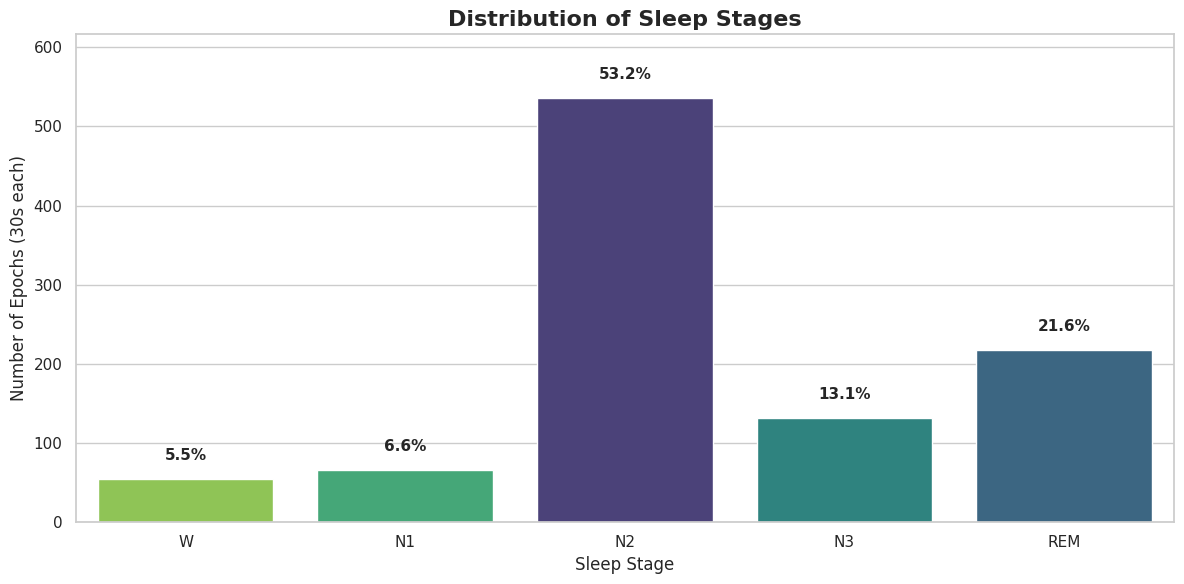

=== DISTRIBUTION OF INTERNSHIPS ===
N2: 536 epochs (53.2%) = 268 minutes
REM: 218 epochs (21.6%) = 109 minutes
N3: 132 epochs (13.1%) = 66 minutes
N1: 66 epochs (6.6%) = 33 minutes
W: 55 epochs (5.5%) = 28 minutes


In [22]:
cls_counts = df["stage"].value_counts(sort=True)
cls_counts = cls_counts.with_columns(
    (pl.col("count") / pl.col("count").sum()).alias("proportion")
).with_columns(
    pl.col("stage").cast(pl.String)
)

stage_order = ["W", "N1", "N2", "N3", "REM"]

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=cls_counts.to_pandas(), 
    x="stage", 
    y="count",
    order=stage_order,
    palette="viridis",
    hue="stage",
    legend=False
)

for i, (stage, row) in enumerate(cls_counts.to_pandas().iterrows()):
    if row['stage'] in stage_order:
        ax.text(stage_order.index(row['stage']), row['count'] + 20, 
                f"{row['proportion']:.1%}", 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title("Distribution of Sleep Stages", fontsize=16, fontweight='bold')
ax.set_xlabel("Sleep Stage", fontsize=12)
ax.set_ylabel("Number of Epochs (30s each)", fontsize=12)
ax.set_ylim(0, cls_counts["count"].max() * 1.15)

plt.tight_layout()
plt.show()

print("=== DISTRIBUTION OF INTERNSHIPS ===")
for row in cls_counts.to_pandas().itertuples():
    minutes = row.count * 0.5  
    print(f"{row.stage}: {row.count:,} epochs ({row.proportion:.1%}) = {minutes:.0f} minutes")

### 3.2 Temporal Distribution of Stages

Sleep has a characteristic temporal architecture. Let's analyze how the stages are distributed throughout the night:

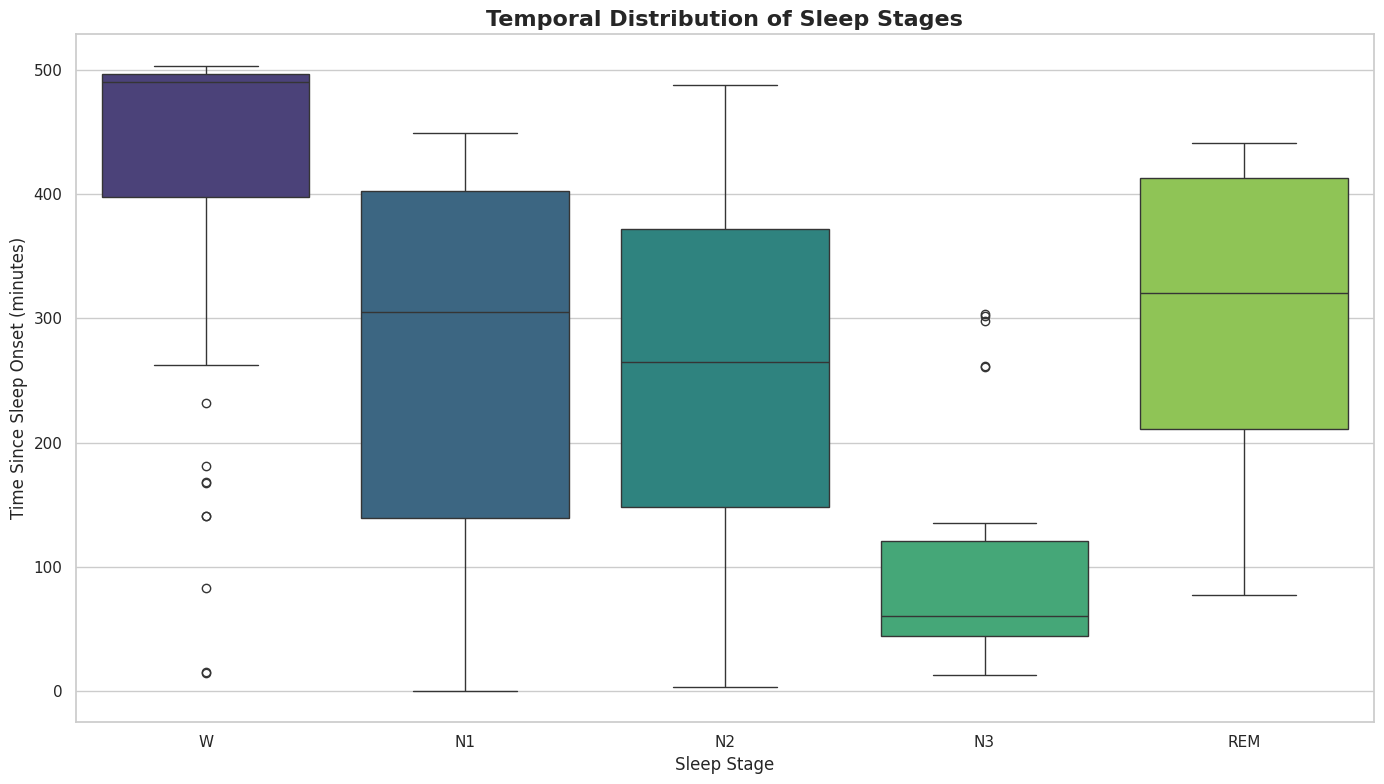

### Temporal Distribution per Stage

stage,mean_minutes,median_minutes,std_minutes,p10_minutes,p90_minutes
N3,86.4,60.8,55.1,34.5,131.0
N2,257.1,265.2,140.1,69.0,461.5
N1,257.5,305.2,158.2,16.0,446.5
REM,298.5,320.2,103.7,194.5,429.0
W,406.3,490.0,139.8,167.5,501.0


### Key Feature Distributions per Stage

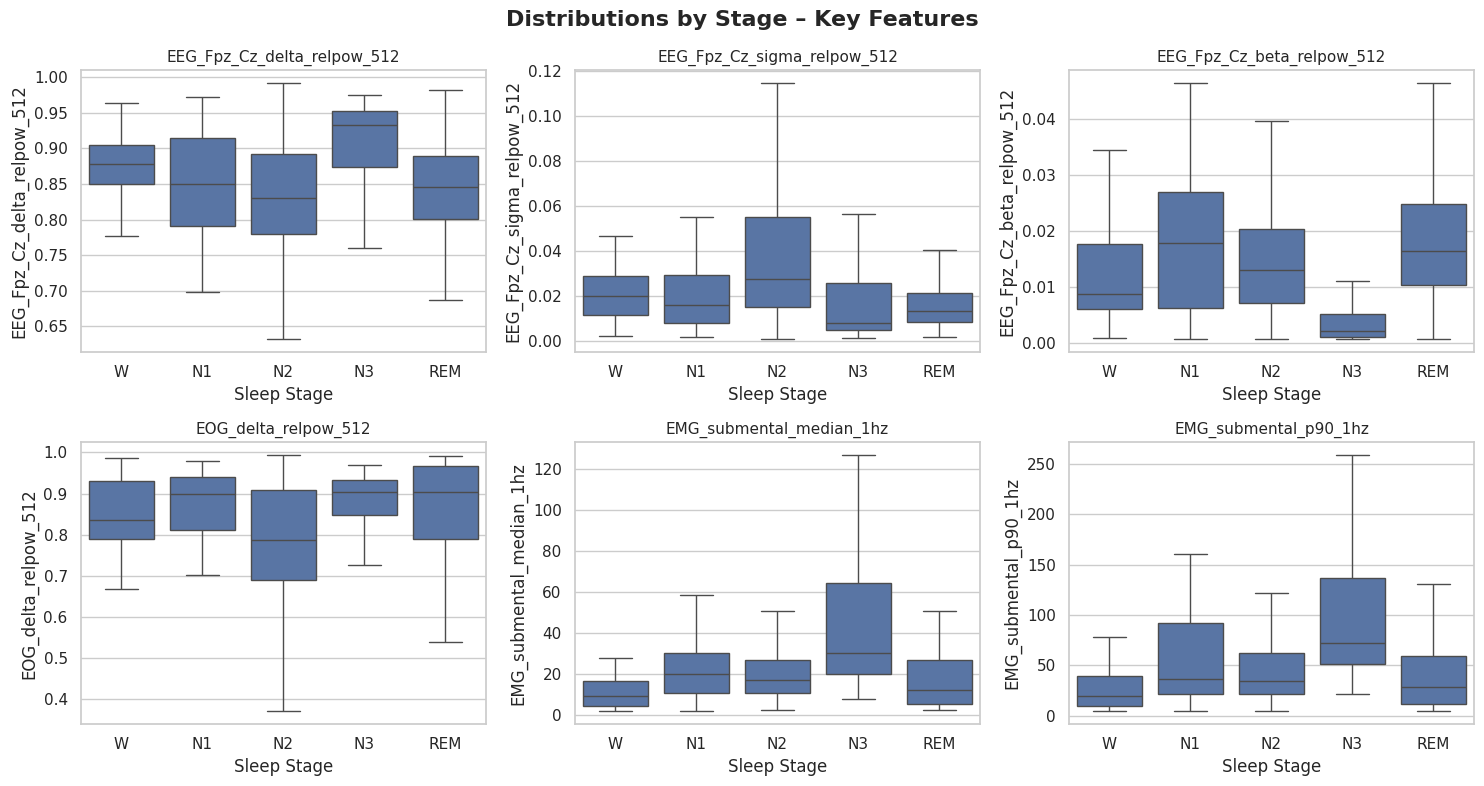

### Spearman Correlation with TSO — Temporal Redundancy

feature,spearman_rho,p_value
EMG_submental_p90_1hz,-0.344,2.37e-29
EMG_submental_median_1hz,-0.311,5.78e-24
EEG_Fpz_Cz_beta_relpow_512,0.289,7.23e-21
EEG_Fpz_Cz_delta_relpow_512,-0.217,3.73e-12
EOG_delta_relpow_512,-0.158,4.54e-07
EEG_Fpz_Cz_sigma_relpow_512,0.143,5.2e-06


### Stage Discrimination (Kruskal H and η²)

feature,H,p_value,eta2,n
tso_min,255.258,4.79e-54,0.251,"1,007"
EEG_Fpz_Cz_beta_relpow_512,174.485,1.14e-36,0.170,"1,007"
EEG_Fpz_Cz_sigma_relpow_512,132.934,9.18e-28,0.129,"1,007"
EMG_submental_p90_1hz,131.187,2.17e-27,0.127,"1,007"
EEG_Fpz_Cz_delta_relpow_512,119.443,7.03e-25,0.115,"1,007"
EMG_submental_median_1hz,118.682,1.02e-24,0.114,"1,007"
EOG_delta_relpow_512,114.300,8.8e-24,0.110,"1,007"


### Suggested Temporal Core — Candidate Features to Keep

feature
EEG_Fpz_Cz_delta_relpow_512
EEG_Fpz_Cz_sigma_relpow_512
EEG_Fpz_Cz_beta_relpow_512
EOG_delta_relpow_512
EMG_submental_median_1hz
EMG_submental_p90_1hz



> **Reading tips**
> - **Temporal Distribution per Stage**: sanity check that N3 clusters earlier (lower minutes) and REM later.
> - **Spearman with TSO**: high |rho| ⇒ feature might encode time-in-night; use carefully to avoid leakage.
> - **Kruskal η²**: rough effect size across stages (≥0.06 ~ medium). Prioritize features with higher η².
> - **Suggested Core**: pragmatic shortlist balancing discrimination vs temporal redundancy.


In [23]:
plt.figure(figsize=(14, 8))
ax = sns.boxplot(
    data=df.to_pandas(),
    x="stage",
    y="tso_min",
    order=stage_order,
    palette="viridis",
    hue="stage",
    legend=False
)
ax.set_title('Temporal Distribution of Sleep Stages', fontsize=16, fontweight='bold')
ax.set_xlabel('Sleep Stage', fontsize=12)
ax.set_ylabel('Time Since Sleep Onset (minutes)', fontsize=12)
plt.tight_layout()
plt.show()

temporal_stats = (
    df.group_by("stage")
      .agg([
          pl.col("tso_min").mean().alias("mean_minutes"),
          pl.col("tso_min").median().alias("median_minutes"),
          pl.col("tso_min").std().alias("std_minutes"),
          pl.col("tso_min").quantile(0.1).alias("p10_minutes"),
          pl.col("tso_min").quantile(0.9).alias("p90_minutes"),
      ])
      .sort("mean_minutes")
)

display(Markdown("### Temporal Distribution per Stage"))
ts_pd = temporal_stats.to_pandas()
display(
    ts_pd.style
        .format({
            "mean_minutes": "{:.1f}",
            "median_minutes": "{:.1f}",
            "std_minutes": "{:.1f}",
            "p10_minutes": "{:.1f}",
            "p90_minutes": "{:.1f}",
        })
        .set_caption("Summary (minutes): mean, median, std, P10, P90")
        .hide(axis="index")
)

key_feats = [
    "EEG_Fpz_Cz_delta_relpow_512",
    "EEG_Fpz_Cz_sigma_relpow_512",
    "EEG_Fpz_Cz_beta_relpow_512",
    "EOG_delta_relpow_512",
    "EMG_submental_median_1hz",
    "EMG_submental_p90_1hz",
]

cols_needed = ["stage", "tso_min"] + [c for c in key_feats if c in df.columns]
df_sub = df.select([c for c in cols_needed if c in df.columns]).to_pandas()

display(Markdown("### Key Feature Distributions per Stage"))
n_cols = 3
present_feats = [c for c in key_feats if c in df_sub.columns]
n_rows = int(np.ceil(len(present_feats) / n_cols)) if len(present_feats) else 1
plt.figure(figsize=(5 * n_cols, 4 * n_rows))
for i, feat in enumerate(present_feats, start=1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(
        data=df_sub,
        x="stage",
        y=feat,
        order=stage_order,
        showfliers=False
    )
    plt.title(feat, fontsize=11)
    plt.xlabel("Sleep Stage"); plt.ylabel(feat)
plt.suptitle("Distributions by Stage – Key Features", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

spearman_rows = []
for feat in [c for c in key_feats if c in df_sub.columns]:
    valid = df_sub[["tso_min", feat]].dropna()
    if len(valid) > 0:
        rho, p = spearmanr(valid["tso_min"], valid[feat])
        spearman_rows.append({"feature": feat, "spearman_rho": rho, "p_value": p})

spearman_df = (
    pd.DataFrame(spearman_rows)
      .sort_values(by="spearman_rho", key=lambda s: s.abs(), ascending=False)
      .reset_index(drop=True)
)

display(Markdown("### Spearman Correlation with TSO — Temporal Redundancy"))
if not spearman_df.empty:
    display(
        spearman_df.style
            .format({"spearman_rho": "{:.3f}", "p_value": "{:.3g}"})
            .set_caption("Correlation between TSO (minutes) and each feature")
            .hide(axis="index")
    )
else:
    display(Markdown("> No key features present to compute Spearman correlation."))

def kruskal_effect_size(feature: str, frame: pd.DataFrame, classes: list[str]) -> dict:
    df_feat = frame[["stage", feature]].dropna()
    n = len(df_feat)
    if n < 10:   
        return {"feature": feature, "H": np.nan, "p_value": np.nan, "eta2": np.nan, "n": n}
    groups = [df_feat.loc[df_feat["stage"] == s, feature].values for s in classes]
    if any(len(g) < 2 for g in groups):
        return {"feature": feature, "H": np.nan, "p_value": np.nan, "eta2": np.nan, "n": n}
    stat, p = kruskal(*groups)
    k = len(groups)
    eta2 = (stat - k + 1) / (n - k) if (n - k) > 0 else np.nan
    return {"feature": feature, "H": stat, "p_value": p, "eta2": eta2, "n": n}

kr_rows = []
for feat in [c for c in key_feats if c in df_sub.columns] + (["tso_min"] if "tso_min" in df_sub.columns else []):
    kr_rows.append(kruskal_effect_size(feat, df_sub, stage_order))

kr_df = pd.DataFrame(kr_rows).sort_values(by="eta2", ascending=False).reset_index(drop=True)

display(Markdown("### Stage Discrimination (Kruskal H and η²)"))
if not kr_df.empty:
    display(
        kr_df.style
            .format({"H": "{:.3f}", "p_value": "{:.3g}", "eta2": "{:.3f}", "n": "{:,.0f}"})
            .set_caption("Higher η² ⇒ stronger separation across sleep stages")
            .hide(axis="index")
    )
else:
    display(Markdown("> Not enough data to compute Kruskal-Wallis statistics."))

selected = []
rho_map = {r["feature"]: r["spearman_rho"] for r in spearman_rows}

for row in kr_rows:
    feat = row["feature"]
    if feat == "tso_min":
        continue
    rho = float(rho_map.get(feat, 0.0))
    if (not np.isnan(row["eta2"])) and row["eta2"] >= 0.06 and abs(rho) <= 0.5:
        selected.append(feat)

display(Markdown("### Suggested Temporal Core — Candidate Features to Keep"))
if selected:
    display(pd.DataFrame({"feature": selected}).style.set_caption(
        "Criteria: η² ≥ 0.06 (medium+) and |Spearman(TSO, feature)| ≤ 0.5"
    ).hide(axis="index"))
else:
    display(Markdown("> No features met the selection criteria. Consider relaxing thresholds or checking data availability."))

display(Markdown(
"""
> **Reading tips**
> - **Temporal Distribution per Stage**: sanity check that N3 clusters earlier (lower minutes) and REM later.
> - **Spearman with TSO**: high |rho| ⇒ feature might encode time-in-night; use carefully to avoid leakage.
> - **Kruskal η²**: rough effect size across stages (≥0.06 ~ medium). Prioritize features with higher η².
> - **Suggested Core**: pragmatic shortlist balancing discrimination vs temporal redundancy.
"""
))

## 4. Feature Behavior by Stage

### 4.1 EEG Features - Spectral Analysis

The EEG is the most important signal for classifying sleep stages. Let's analyze how the different frequency bands behave:

### EEG Relative Power by Sleep Stage — EEG_Fpz_Cz

,delta,theta,alpha,sigma,beta
stage,,,,,
W,0.869,0.067,0.025,0.025,0.014
N1,0.846,0.079,0.027,0.025,0.023
N2,0.827,0.078,0.034,0.042,0.019
N3,0.905,0.050,0.020,0.018,0.007
REM,0.838,0.087,0.028,0.021,0.026


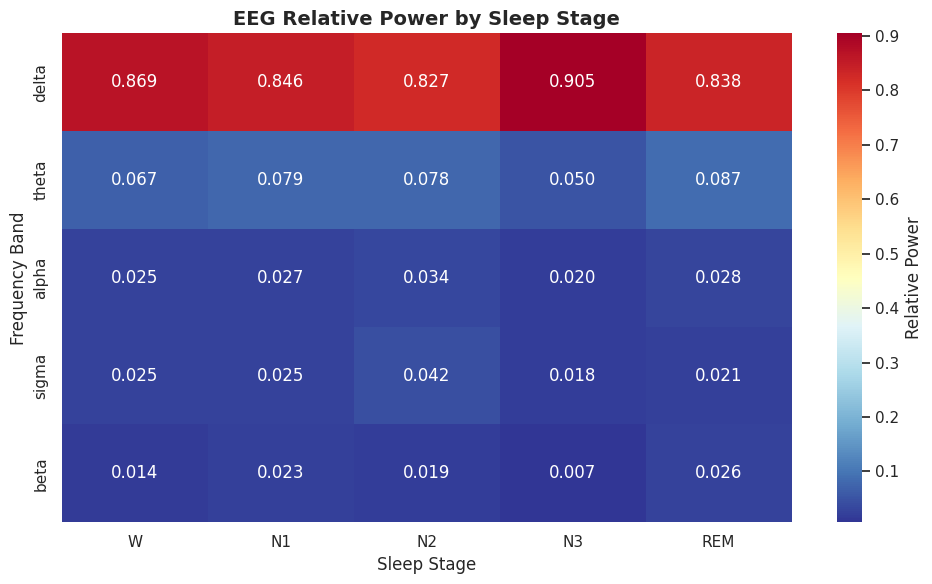

**Clinical reading (rule-of-thumb):**

• Delta (0.5–4 Hz): slow waves, dominant in deep sleep (N3).
• Theta (4–8 Hz): transitional, stronger in N1.
• Alpha (8–12 Hz): eyes-closed relaxation, recedes in sleep.
• Sigma (12–16 Hz): sleep spindles, characteristic of N2.
• Beta (16–30 Hz): fast activity, higher in wake (W).

### EEG Relative Power by Sleep Stage — EEG_Pz_Oz

,delta,theta,alpha,sigma,beta
stage,,,,,
W,0.798,0.106,0.040,0.028,0.028
N1,0.769,0.115,0.046,0.035,0.035
N2,0.771,0.107,0.046,0.047,0.030
N3,0.885,0.064,0.022,0.020,0.009
REM,0.757,0.124,0.051,0.035,0.033


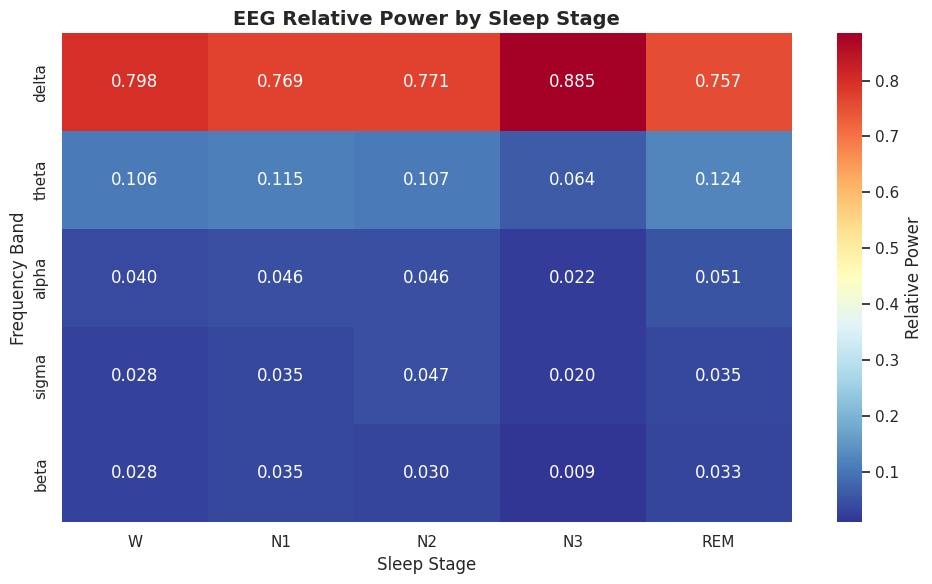

**Clinical reading (rule-of-thumb):**

• Delta (0.5–4 Hz): slow waves, dominant in deep sleep (N3).
• Theta (4–8 Hz): transitional, stronger in N1.
• Alpha (8–12 Hz): eyes-closed relaxation, recedes in sleep.
• Sigma (12–16 Hz): sleep spindles, characteristic of N2.
• Beta (16–30 Hz): fast activity, higher in wake (W).

### EEG Relative Power (Channels × Bands) by Sleep Stage — EEG_Fpz_Cz, EEG_Pz_Oz

,EEG_Fpz_Cz_delta_relpow_256,EEG_Fpz_Cz_theta_relpow_256,EEG_Fpz_Cz_alpha_relpow_256,EEG_Fpz_Cz_sigma_relpow_256,EEG_Fpz_Cz_beta_relpow_256,EEG_Pz_Oz_delta_relpow_256,EEG_Pz_Oz_theta_relpow_256,EEG_Pz_Oz_alpha_relpow_256,EEG_Pz_Oz_sigma_relpow_256,EEG_Pz_Oz_beta_relpow_256
stage,,,,,,,,,,
W,0.869,0.067,0.025,0.025,0.014,0.798,0.106,0.040,0.028,0.028
N1,0.846,0.079,0.027,0.025,0.023,0.769,0.115,0.046,0.035,0.035
N2,0.827,0.078,0.034,0.042,0.019,0.771,0.107,0.046,0.047,0.030
N3,0.905,0.050,0.020,0.018,0.007,0.885,0.064,0.022,0.020,0.009
REM,0.838,0.087,0.028,0.021,0.026,0.757,0.124,0.051,0.035,0.033


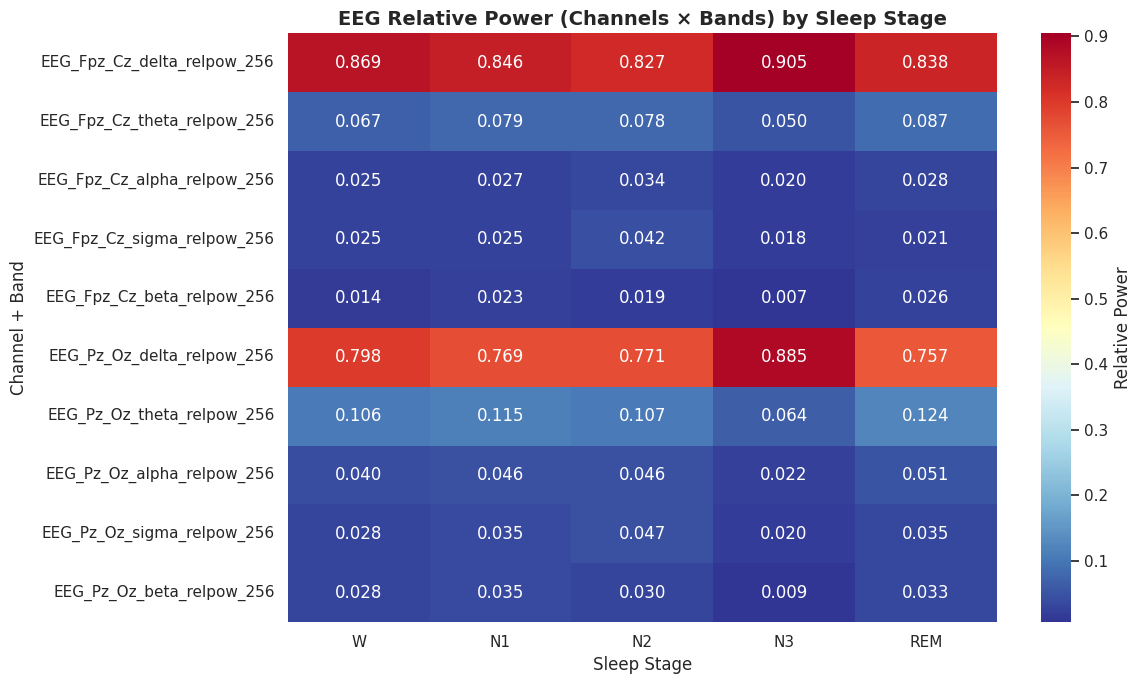

### Stage Discrimination (Kruskal H and η²)

feature,H,p,eta2,n
EEG_Pz_Oz_beta_relpow_256,202.065,1.35e-42,0.198,"1,007"
EEG_Fpz_Cz_beta_relpow_256,173.900,1.52e-36,0.170,"1,007"
EEG_Fpz_Cz_sigma_relpow_256,138.351,6.36e-29,0.134,"1,007"
EEG_Pz_Oz_delta_relpow_256,129.724,4.46e-27,0.125,"1,007"
EEG_Pz_Oz_theta_relpow_256,124.896,4.8e-26,0.121,"1,007"
EEG_Fpz_Cz_delta_relpow_256,119.766,5.99e-25,0.116,"1,007"
EEG_Pz_Oz_alpha_relpow_256,117.436,1.88e-24,0.113,"1,007"
EEG_Fpz_Cz_theta_relpow_256,105.532,6.53e-22,0.101,"1,007"
EEG_Pz_Oz_sigma_relpow_256,102.010,3.67e-21,0.098,"1,007"
EEG_Fpz_Cz_alpha_relpow_256,85.620,1.12e-17,0.081,"1,007"


### Spearman Correlation among Spectral Relative-Power Features

,EEG_Fpz_Cz_delta_relpow_256,EEG_Fpz_Cz_theta_relpow_256,EEG_Fpz_Cz_alpha_relpow_256,EEG_Fpz_Cz_sigma_relpow_256,EEG_Fpz_Cz_beta_relpow_256,EEG_Pz_Oz_delta_relpow_256,EEG_Pz_Oz_theta_relpow_256,EEG_Pz_Oz_alpha_relpow_256,EEG_Pz_Oz_sigma_relpow_256,EEG_Pz_Oz_beta_relpow_256
EEG_Fpz_Cz_delta_relpow_256,1.00,-0.83,-0.89,-0.76,-0.71,0.61,-0.50,-0.53,-0.60,-0.47
EEG_Fpz_Cz_theta_relpow_256,-0.83,1.00,0.64,0.42,0.62,-0.57,0.64,0.50,0.39,0.49
EEG_Fpz_Cz_alpha_relpow_256,-0.89,0.64,1.00,0.83,0.57,-0.55,0.38,0.56,0.67,0.35
EEG_Fpz_Cz_sigma_relpow_256,-0.76,0.42,0.83,1.00,0.34,-0.46,0.23,0.40,0.78,0.19
EEG_Fpz_Cz_beta_relpow_256,-0.71,0.62,0.57,0.34,1.00,-0.51,0.47,0.48,0.29,0.70
EEG_Pz_Oz_delta_relpow_256,0.61,-0.57,-0.55,-0.46,-0.51,1.00,-0.83,-0.91,-0.76,-0.78
EEG_Pz_Oz_theta_relpow_256,-0.50,0.64,0.38,0.23,0.47,-0.83,1.00,0.74,0.44,0.67
EEG_Pz_Oz_alpha_relpow_256,-0.53,0.50,0.56,0.40,0.48,-0.91,0.74,1.00,0.71,0.75
EEG_Pz_Oz_sigma_relpow_256,-0.60,0.39,0.67,0.78,0.29,-0.76,0.44,0.71,1.00,0.49
EEG_Pz_Oz_beta_relpow_256,-0.47,0.49,0.35,0.19,0.70,-0.78,0.67,0.75,0.49,1.00


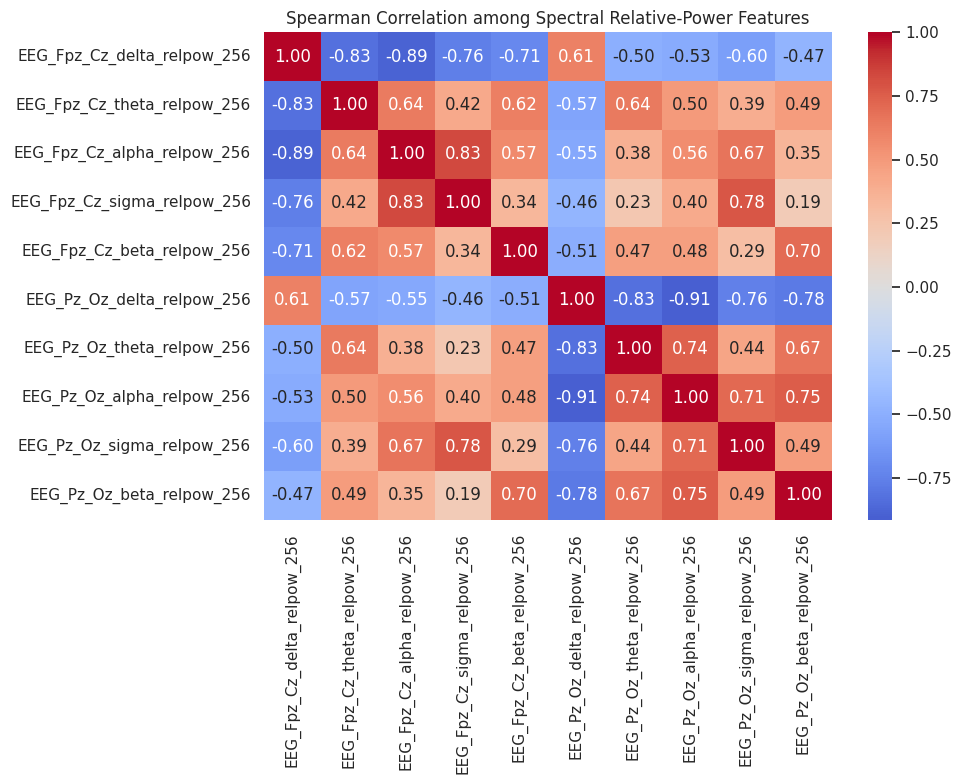

**Clinical reading (rule-of-thumb):**

• Delta (0.5–4 Hz): slow waves, dominant in deep sleep (N3).
• Theta (4–8 Hz): transitional, stronger in N1.
• Alpha (8–12 Hz): eyes-closed relaxation, recedes in sleep.
• Sigma (12–16 Hz): sleep spindles, characteristic of N2.
• Beta (16–30 Hz): fast activity, higher in wake (W).

In [24]:
def spectral_panel(
    df,
    channels=("EEG_Fpz_Cz",),
    bands=("delta","theta","alpha","sigma","beta"),
    fsuffix="_relpow_256",
    stage_col="stage",
    stage_order=None,
    show_stats=True,
    lang="en"
):
    L = {
        "en": {
            "title_quick": "EEG Relative Power by Sleep Stage",
            "title_full": "EEG Relative Power (Channels × Bands) by Sleep Stage",
            "x_stage": "Sleep Stage",
            "y_band": "Frequency Band",
            "y_chanband": "Channel + Band",
            "cbar": "Relative Power",
            "clinical": "Clinical reading (rule-of-thumb)",
            "clinical_bullets": [
                "Delta (0.5–4 Hz): slow waves, dominant in deep sleep (N3).",
                "Theta (4–8 Hz): transitional, stronger in N1.",
                "Alpha (8–12 Hz): eyes-closed relaxation, recedes in sleep.",
                "Sigma (12–16 Hz): sleep spindles, characteristic of N2.",
                "Beta (16–30 Hz): fast activity, higher in wake (W).",
            ],
            "stats_title": "Stage Discrimination (Kruskal H and η²)",
            "stats_caption": "Higher η² ⇒ stronger separation across stages",
            "corr_title": "Spearman Correlation among Spectral Relative-Power Features",
            "heatmap_caption": "Values are mean relative power (0–1) per stage",
            "note_no_features": "> No matching features found in the dataframe.",
        }
    }[lang]

    band_features = [f"{ch}_{b}{fsuffix}" for ch in channels for b in bands]
    present = [f for f in band_features if f in df.columns]
    if not present:
        display(Markdown(L["note_no_features"]))
        return

    spectral_means = (
        df.group_by(stage_col)
          .agg([pl.col(f).mean().alias(f) for f in present])
          .to_pandas()
          .set_index(stage_col)
    )
    if stage_order is not None:
        spectral_means = spectral_means.reindex(stage_order)

    if len(channels) == 1:
        ch = channels[0]
        rename_map = {f"{ch}_{b}{fsuffix}": b for b in bands if f"{ch}_{b}{fsuffix}" in spectral_means.columns}
        quick_df = spectral_means.rename(columns=rename_map)
        display(Markdown(f"### {L['title_quick']} — {ch}"))
        display(
            quick_df.style
                .format("{:.3f}")
                .set_caption(L["heatmap_caption"])
        )
        plt.figure(figsize=(10, 6))
        sns.heatmap(quick_df.T, annot=True, fmt=".3f", cmap="RdYlBu_r",
                    cbar_kws={'label': L["cbar"]})
        plt.title(L["title_quick"], fontsize=14, fontweight="bold")
        plt.xlabel(L["x_stage"])
        plt.ylabel(L["y_band"])
        plt.tight_layout()
        plt.show()

    else:
        display(Markdown(f"### {L['title_full']} — {', '.join(channels)}"))
        display(
            spectral_means.style
                .format("{:.3f}")
                .set_caption(L["heatmap_caption"])
        )
        plt.figure(figsize=(12, 7))
        sns.heatmap(spectral_means.T, annot=True, fmt=".3f", cmap="RdYlBu_r",
                    cbar_kws={'label': L["cbar"]})
        plt.title(L["title_full"], fontsize=14, fontweight="bold")
        plt.xlabel(L["x_stage"])
        plt.ylabel(L["y_chanband"])
        plt.tight_layout()
        plt.show()

    if show_stats:
        def kruskal_eta2_polars(df_pl, feature, stage_col="stage"):
            df_feat = df_pl.select([stage_col, feature]).drop_nulls().to_pandas()
            if stage_order is not None:
                groups = [df_feat.loc[df_feat[stage_col] == s, feature] for s in stage_order]
            else:
                groups = [g[feature] for _, g in df_feat.groupby(stage_col)]
            if any(len(g) < 2 for g in groups): 
                return None
            from scipy.stats import kruskal
            H, p = kruskal(*groups)
            n = len(df_feat)
            k = len(groups)
            eta2 = (H - k + 1) / (n - k) if (n - k) > 0 else np.nan
            return {"feature": feature, "H": H, "p": p, "eta2": eta2, "n": n}

        results = [kruskal_eta2_polars(df, f, stage_col=stage_col) for f in present]
        results = [r for r in results if r]
        if results:
            res_df = pd.DataFrame(results).sort_values("eta2", ascending=False).reset_index(drop=True)
            display(Markdown(f"### {L['stats_title']}"))
            display(
                res_df.style
                    .format({"H": "{:.3f}", "p": "{:.3g}", "eta2": "{:.3f}", "n": "{:,.0f}"})
                    .set_caption(L["stats_caption"])
                    .hide(axis="index")
            )

        corr = df.select(present).to_pandas().corr(method="spearman")
        display(Markdown(f"### {L['corr_title']}"))
        display(corr.style.format("{:.2f}").background_gradient(cmap="coolwarm", axis=None))
        plt.figure(figsize=(max(8, 0.4*len(present)+6), max(6, 0.4*len(present)+4)))
        sns.heatmap(corr, cmap="coolwarm", center=0, annot=True, fmt=".2f")
        plt.title(L["corr_title"])
        plt.tight_layout()
        plt.show()

    display(Markdown(f"**{L['clinical']}:**"))
    display(Markdown("• " + "\n• ".join(L["clinical_bullets"])))

spectral_panel(df, channels=("EEG_Fpz_Cz",), stage_order=stage_order, show_stats=False, lang="en")
spectral_panel(df, channels=("EEG_Pz_Oz",), stage_order=stage_order, show_stats=False, lang="en")
spectral_panel(df, channels=("EEG_Fpz_Cz","EEG_Pz_Oz"), stage_order=stage_order, show_stats=True, lang="en")

### EEG Relative Power by Sleep Stage — EEG_Fpz_Cz

,delta,theta,alpha,sigma,beta
stage,,,,,
W,0.873,0.066,0.025,0.023,0.013
N1,0.852,0.077,0.026,0.023,0.021
N2,0.831,0.077,0.034,0.039,0.019
N3,0.909,0.048,0.020,0.017,0.006
REM,0.840,0.086,0.028,0.020,0.026


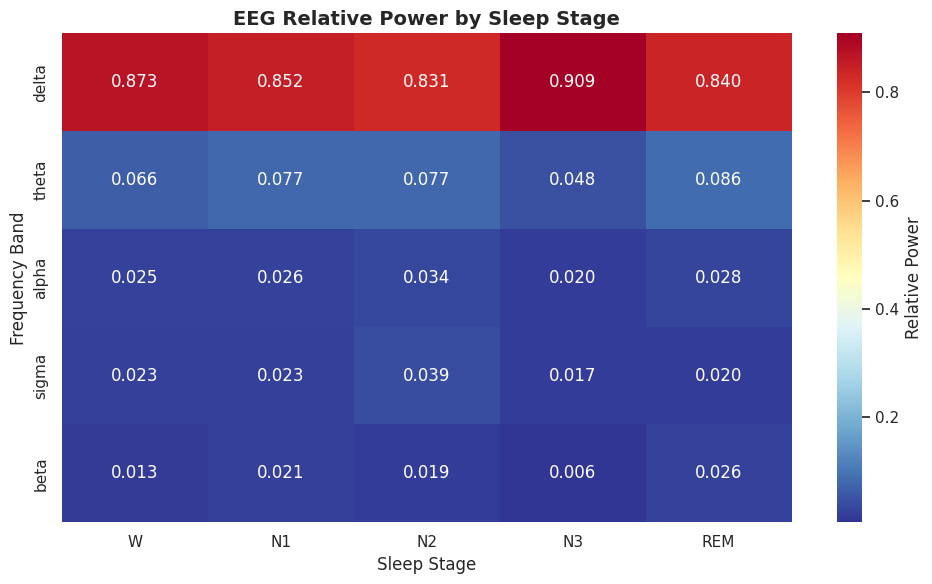

**Clinical reading (rule-of-thumb):**

• Delta (0.5–4 Hz): slow waves, dominant in deep sleep (N3).
• Theta (4–8 Hz): transitional, stronger in N1.
• Alpha (8–12 Hz): eyes-closed relaxation, recedes in sleep.
• Sigma (12–16 Hz): sleep spindles, characteristic of N2.
• Beta (16–30 Hz): fast activity, higher in wake (W).

### EEG Relative Power by Sleep Stage — EEG_Pz_Oz

,delta,theta,alpha,sigma,beta
stage,,,,,
W,0.808,0.102,0.039,0.025,0.026
N1,0.778,0.111,0.046,0.032,0.033
N2,0.777,0.104,0.046,0.044,0.029
N3,0.890,0.061,0.022,0.018,0.009
REM,0.760,0.123,0.052,0.033,0.032


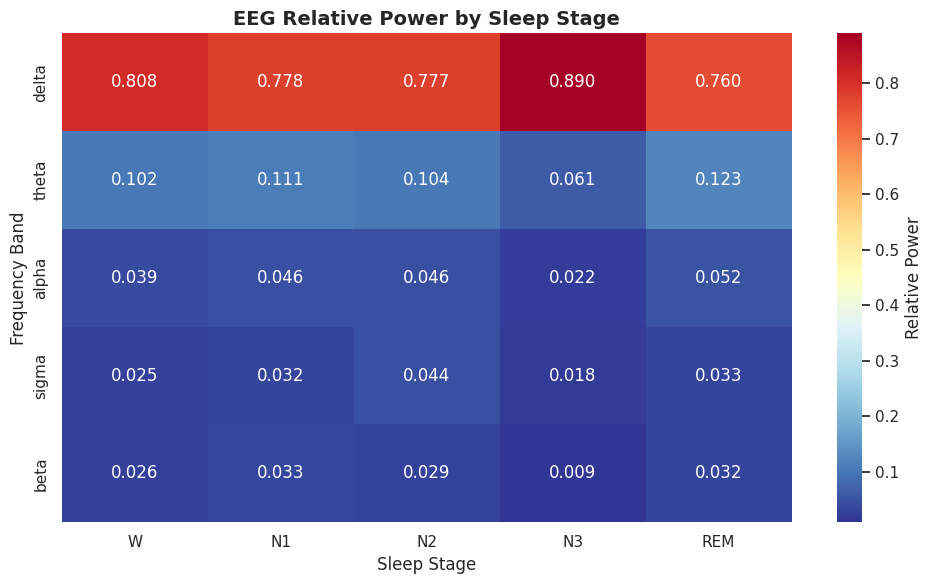

**Clinical reading (rule-of-thumb):**

• Delta (0.5–4 Hz): slow waves, dominant in deep sleep (N3).
• Theta (4–8 Hz): transitional, stronger in N1.
• Alpha (8–12 Hz): eyes-closed relaxation, recedes in sleep.
• Sigma (12–16 Hz): sleep spindles, characteristic of N2.
• Beta (16–30 Hz): fast activity, higher in wake (W).

### EEG Relative Power (Channels × Bands) by Sleep Stage — EEG_Fpz_Cz, EEG_Pz_Oz

,EEG_Fpz_Cz_delta_relpow_512,EEG_Fpz_Cz_theta_relpow_512,EEG_Fpz_Cz_alpha_relpow_512,EEG_Fpz_Cz_sigma_relpow_512,EEG_Fpz_Cz_beta_relpow_512,EEG_Pz_Oz_delta_relpow_512,EEG_Pz_Oz_theta_relpow_512,EEG_Pz_Oz_alpha_relpow_512,EEG_Pz_Oz_sigma_relpow_512,EEG_Pz_Oz_beta_relpow_512
stage,,,,,,,,,,
W,0.873,0.066,0.025,0.023,0.013,0.808,0.102,0.039,0.025,0.026
N1,0.852,0.077,0.026,0.023,0.021,0.778,0.111,0.046,0.032,0.033
N2,0.831,0.077,0.034,0.039,0.019,0.777,0.104,0.046,0.044,0.029
N3,0.909,0.048,0.020,0.017,0.006,0.890,0.061,0.022,0.018,0.009
REM,0.840,0.086,0.028,0.020,0.026,0.760,0.123,0.052,0.033,0.032


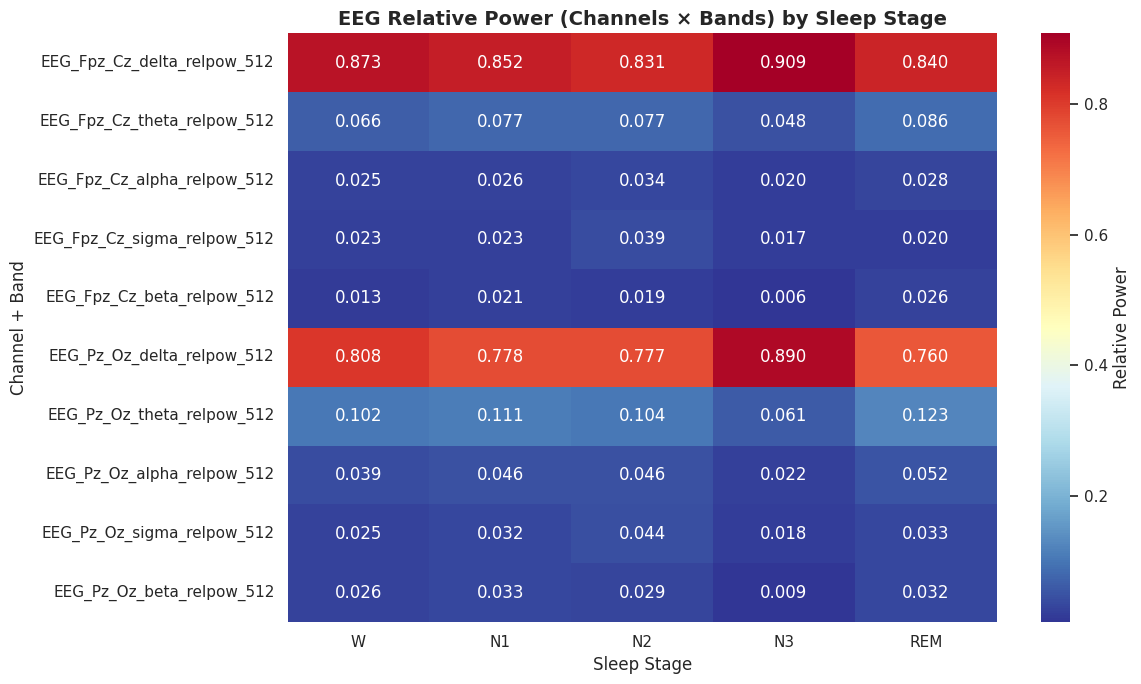

### Stage Discrimination (Kruskal H and η²)

feature,H,p,eta2,n
EEG_Pz_Oz_beta_relpow_512,205.440,2.54e-43,0.201,"1,007"
EEG_Fpz_Cz_beta_relpow_512,174.485,1.14e-36,0.170,"1,007"
EEG_Pz_Oz_delta_relpow_512,135.091,3.17e-28,0.131,"1,007"
EEG_Fpz_Cz_sigma_relpow_512,132.934,9.18e-28,0.129,"1,007"
EEG_Pz_Oz_theta_relpow_512,130.223,3.49e-27,0.126,"1,007"
EEG_Pz_Oz_alpha_relpow_512,120.175,4.9e-25,0.116,"1,007"
EEG_Fpz_Cz_delta_relpow_512,119.443,7.03e-25,0.115,"1,007"
EEG_Fpz_Cz_theta_relpow_512,106.736,3.61e-22,0.103,"1,007"
EEG_Pz_Oz_sigma_relpow_512,101.657,4.37e-21,0.097,"1,007"
EEG_Fpz_Cz_alpha_relpow_512,86.404,7.64e-18,0.082,"1,007"


### Spearman Correlation among Spectral Relative-Power Features

,EEG_Fpz_Cz_delta_relpow_512,EEG_Fpz_Cz_theta_relpow_512,EEG_Fpz_Cz_alpha_relpow_512,EEG_Fpz_Cz_sigma_relpow_512,EEG_Fpz_Cz_beta_relpow_512,EEG_Pz_Oz_delta_relpow_512,EEG_Pz_Oz_theta_relpow_512,EEG_Pz_Oz_alpha_relpow_512,EEG_Pz_Oz_sigma_relpow_512,EEG_Pz_Oz_beta_relpow_512
EEG_Fpz_Cz_delta_relpow_512,1.00,-0.84,-0.89,-0.75,-0.73,0.61,-0.51,-0.53,-0.59,-0.48
EEG_Fpz_Cz_theta_relpow_512,-0.84,1.00,0.65,0.43,0.64,-0.56,0.64,0.49,0.38,0.49
EEG_Fpz_Cz_alpha_relpow_512,-0.89,0.65,1.00,0.82,0.58,-0.54,0.39,0.54,0.66,0.36
EEG_Fpz_Cz_sigma_relpow_512,-0.75,0.43,0.82,1.00,0.36,-0.45,0.24,0.39,0.78,0.20
EEG_Fpz_Cz_beta_relpow_512,-0.73,0.64,0.58,0.36,1.00,-0.54,0.51,0.50,0.32,0.71
EEG_Pz_Oz_delta_relpow_512,0.61,-0.56,-0.54,-0.45,-0.54,1.00,-0.85,-0.91,-0.75,-0.80
EEG_Pz_Oz_theta_relpow_512,-0.51,0.64,0.39,0.24,0.51,-0.85,1.00,0.74,0.45,0.68
EEG_Pz_Oz_alpha_relpow_512,-0.53,0.49,0.54,0.39,0.50,-0.91,0.74,1.00,0.71,0.77
EEG_Pz_Oz_sigma_relpow_512,-0.59,0.38,0.66,0.78,0.32,-0.75,0.45,0.71,1.00,0.50
EEG_Pz_Oz_beta_relpow_512,-0.48,0.49,0.36,0.20,0.71,-0.80,0.68,0.77,0.50,1.00


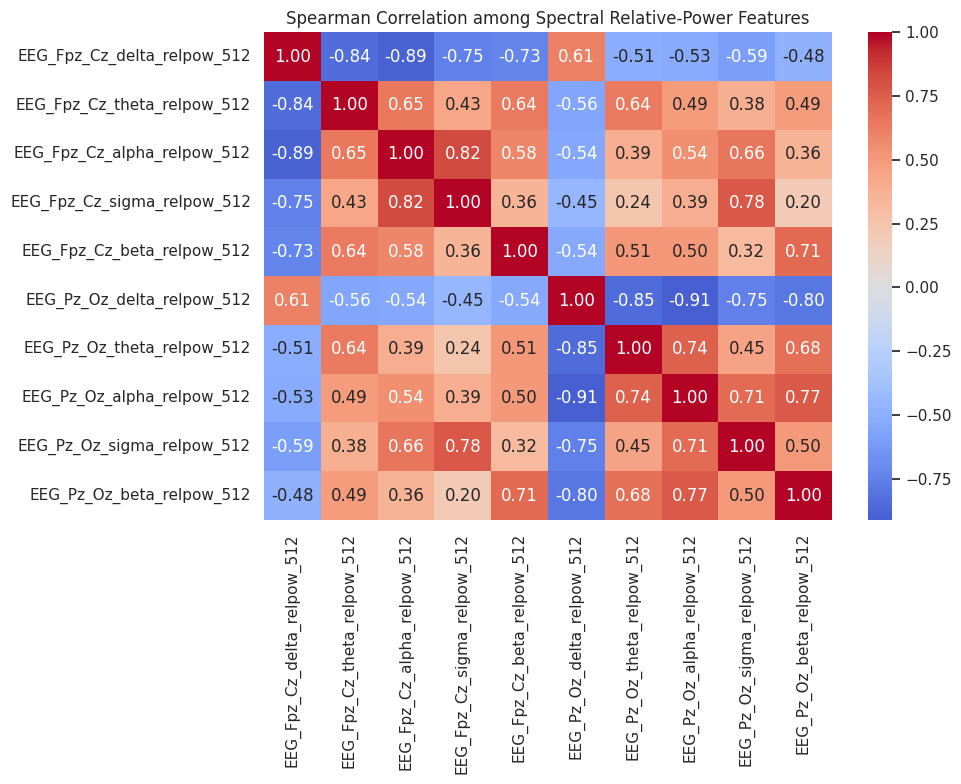

**Clinical reading (rule-of-thumb):**

• Delta (0.5–4 Hz): slow waves, dominant in deep sleep (N3).
• Theta (4–8 Hz): transitional, stronger in N1.
• Alpha (8–12 Hz): eyes-closed relaxation, recedes in sleep.
• Sigma (12–16 Hz): sleep spindles, characteristic of N2.
• Beta (16–30 Hz): fast activity, higher in wake (W).

In [25]:
def spectral_panel(
    df,
    channels=("EEG_Fpz_Cz",),
    bands=("delta","theta","alpha","sigma","beta"),
    fsuffix="_relpow_512",
    stage_col="stage",
    stage_order=None,
    show_stats=True,
    lang="en"
):
    L = {
        "en": {
            "title_quick": "EEG Relative Power by Sleep Stage",
            "title_full": "EEG Relative Power (Channels × Bands) by Sleep Stage",
            "x_stage": "Sleep Stage",
            "y_band": "Frequency Band",
            "y_chanband": "Channel + Band",
            "cbar": "Relative Power",
            "clinical": "Clinical reading (rule-of-thumb)",
            "clinical_bullets": [
                "Delta (0.5–4 Hz): slow waves, dominant in deep sleep (N3).",
                "Theta (4–8 Hz): transitional, stronger in N1.",
                "Alpha (8–12 Hz): eyes-closed relaxation, recedes in sleep.",
                "Sigma (12–16 Hz): sleep spindles, characteristic of N2.",
                "Beta (16–30 Hz): fast activity, higher in wake (W).",
            ],
            "stats_title": "Stage Discrimination (Kruskal H and η²)",
            "stats_caption": "Higher η² ⇒ stronger separation across stages",
            "corr_title": "Spearman Correlation among Spectral Relative-Power Features",
            "heatmap_caption": "Values are mean relative power (0–1) per stage",
            "note_no_features": "> No matching features found in the dataframe.",
        }
    }[lang]

    band_features = [f"{ch}_{b}{fsuffix}" for ch in channels for b in bands]
    present = [f for f in band_features if f in df.columns]
    if not present:
        display(Markdown(L["note_no_features"]))
        return

    spectral_means = (
        df.group_by(stage_col)
          .agg([pl.col(f).mean().alias(f) for f in present])
          .to_pandas()
          .set_index(stage_col)
    )
    if stage_order is not None:
        spectral_means = spectral_means.reindex(stage_order)

    if len(channels) == 1:
        ch = channels[0]
        rename_map = {f"{ch}_{b}{fsuffix}": b for b in bands if f"{ch}_{b}{fsuffix}" in spectral_means.columns}
        quick_df = spectral_means.rename(columns=rename_map)
        display(Markdown(f"### {L['title_quick']} — {ch}"))
        display(
            quick_df.style
                .format("{:.3f}")
                .set_caption(L["heatmap_caption"])
        )
        plt.figure(figsize=(10, 6))
        sns.heatmap(quick_df.T, annot=True, fmt=".3f", cmap="RdYlBu_r",
                    cbar_kws={'label': L["cbar"]})
        plt.title(L["title_quick"], fontsize=14, fontweight="bold")
        plt.xlabel(L["x_stage"])
        plt.ylabel(L["y_band"])
        plt.tight_layout()
        plt.show()

    else:
        display(Markdown(f"### {L['title_full']} — {', '.join(channels)}"))
        display(
            spectral_means.style
                .format("{:.3f}")
                .set_caption(L["heatmap_caption"])
        )
        plt.figure(figsize=(12, 7))
        sns.heatmap(spectral_means.T, annot=True, fmt=".3f", cmap="RdYlBu_r",
                    cbar_kws={'label': L["cbar"]})
        plt.title(L["title_full"], fontsize=14, fontweight="bold")
        plt.xlabel(L["x_stage"])
        plt.ylabel(L["y_chanband"])
        plt.tight_layout()
        plt.show()

    if show_stats:
        def kruskal_eta2_polars(df_pl, feature, stage_col="stage"):
            df_feat = df_pl.select([stage_col, feature]).drop_nulls().to_pandas()
            if stage_order is not None:
                groups = [df_feat.loc[df_feat[stage_col] == s, feature] for s in stage_order]
            else:
                groups = [g[feature] for _, g in df_feat.groupby(stage_col)]
            if any(len(g) < 2 for g in groups): 
                return None
            from scipy.stats import kruskal
            H, p = kruskal(*groups)
            n = len(df_feat)
            k = len(groups)
            eta2 = (H - k + 1) / (n - k) if (n - k) > 0 else np.nan
            return {"feature": feature, "H": H, "p": p, "eta2": eta2, "n": n}

        results = [kruskal_eta2_polars(df, f, stage_col=stage_col) for f in present]
        results = [r for r in results if r]
        if results:
            res_df = pd.DataFrame(results).sort_values("eta2", ascending=False).reset_index(drop=True)
            display(Markdown(f"### {L['stats_title']}"))
            display(
                res_df.style
                    .format({"H": "{:.3f}", "p": "{:.3g}", "eta2": "{:.3f}", "n": "{:,.0f}"})
                    .set_caption(L["stats_caption"])
                    .hide(axis="index")
            )

        corr = df.select(present).to_pandas().corr(method="spearman")
        display(Markdown(f"### {L['corr_title']}"))
        display(corr.style.format("{:.2f}").background_gradient(cmap="coolwarm", axis=None))
        plt.figure(figsize=(max(8, 0.4*len(present)+6), max(6, 0.4*len(present)+4)))
        sns.heatmap(corr, cmap="coolwarm", center=0, annot=True, fmt=".2f")
        plt.title(L["corr_title"])
        plt.tight_layout()
        plt.show()

    display(Markdown(f"**{L['clinical']}:**"))
    display(Markdown("• " + "\n• ".join(L["clinical_bullets"])))

spectral_panel(df, channels=("EEG_Fpz_Cz",), stage_order=stage_order, show_stats=False, lang="en")
spectral_panel(df, channels=("EEG_Pz_Oz",), stage_order=stage_order, show_stats=False, lang="en")
spectral_panel(df, channels=("EEG_Fpz_Cz","EEG_Pz_Oz"), stage_order=stage_order, show_stats=True, lang="en")

### EEG Relative Power by Sleep Stage — EMG_submental

,delta,theta,alpha,sigma,beta
stage,,,,,
W,0.744,0.053,0.033,0.029,0.141
N1,0.722,0.058,0.039,0.033,0.148
N2,0.700,0.057,0.038,0.033,0.172
N3,0.710,0.073,0.038,0.028,0.151
REM,0.712,0.059,0.039,0.036,0.155


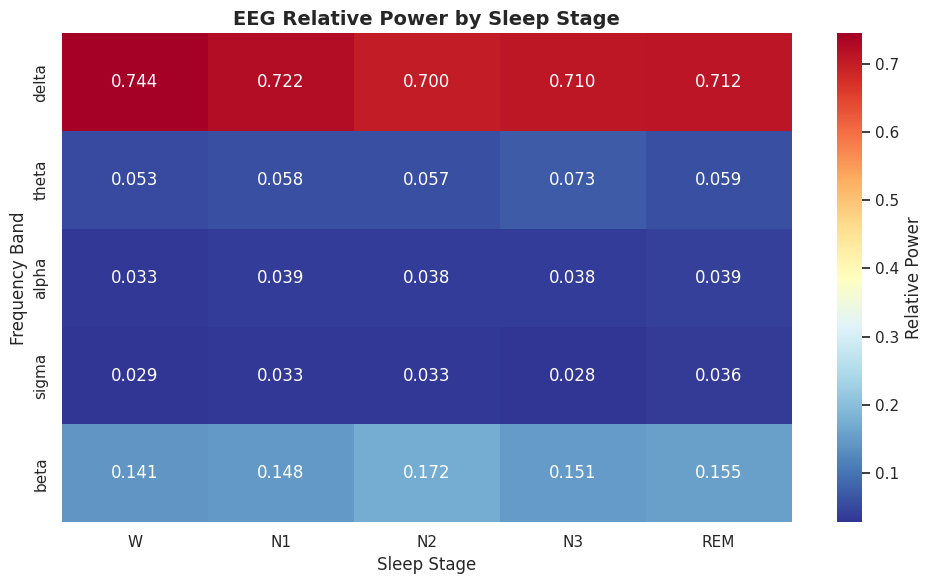

**Clinical reading (rule-of-thumb):**

• Delta (0.5–4 Hz): slow waves, dominant in deep sleep (N3).
• Theta (4–8 Hz): transitional, stronger in N1.
• Alpha (8–12 Hz): eyes-closed relaxation, recedes in sleep.
• Sigma (12–16 Hz): sleep spindles, characteristic of N2.
• Beta (16–30 Hz): fast activity, higher in wake (W).

In [26]:
def spectral_panel(
    df,
    channels=("EMG_submental",),
    bands=("delta","theta","alpha","sigma","beta"),
    fsuffix="_relpow_256",
    stage_col="stage",
    stage_order=None,
    show_stats=True,
    lang="en"
):
    L = {
        "en": {
            "title_quick": "EEG Relative Power by Sleep Stage",
            "title_full": "EEG Relative Power (Channels × Bands) by Sleep Stage",
            "x_stage": "Sleep Stage",
            "y_band": "Frequency Band",
            "y_chanband": "Channel + Band",
            "cbar": "Relative Power",
            "clinical": "Clinical reading (rule-of-thumb)",
            "clinical_bullets": [
                "Delta (0.5–4 Hz): slow waves, dominant in deep sleep (N3).",
                "Theta (4–8 Hz): transitional, stronger in N1.",
                "Alpha (8–12 Hz): eyes-closed relaxation, recedes in sleep.",
                "Sigma (12–16 Hz): sleep spindles, characteristic of N2.",
                "Beta (16–30 Hz): fast activity, higher in wake (W).",
            ],
            "stats_title": "Stage Discrimination (Kruskal H and η²)",
            "stats_caption": "Higher η² ⇒ stronger separation across stages",
            "corr_title": "Spearman Correlation among Spectral Relative-Power Features",
            "heatmap_caption": "Values are mean relative power (0–1) per stage",
            "note_no_features": "> No matching features found in the dataframe.",
        }
    }[lang]

    band_features = [f"{ch}_{b}{fsuffix}" for ch in channels for b in bands]
    present = [f for f in band_features if f in df.columns]
    if not present:
        display(Markdown(L["note_no_features"]))
        return

    spectral_means = (
        df.group_by(stage_col)
          .agg([pl.col(f).mean().alias(f) for f in present])
          .to_pandas()
          .set_index(stage_col)
    )
    if stage_order is not None:
        spectral_means = spectral_means.reindex(stage_order)

    if len(channels) == 1:
        ch = channels[0]
        rename_map = {f"{ch}_{b}{fsuffix}": b for b in bands if f"{ch}_{b}{fsuffix}" in spectral_means.columns}
        quick_df = spectral_means.rename(columns=rename_map)
        display(Markdown(f"### {L['title_quick']} — {ch}"))
        display(
            quick_df.style
                .format("{:.3f}")
                .set_caption(L["heatmap_caption"])
        )
        plt.figure(figsize=(10, 6))
        sns.heatmap(quick_df.T, annot=True, fmt=".3f", cmap="RdYlBu_r",
                    cbar_kws={'label': L["cbar"]})
        plt.title(L["title_quick"], fontsize=14, fontweight="bold")
        plt.xlabel(L["x_stage"])
        plt.ylabel(L["y_band"])
        plt.tight_layout()
        plt.show()

    else:
        display(Markdown(f"### {L['title_full']} — {', '.join(channels)}"))
        display(
            spectral_means.style
                .format("{:.3f}")
                .set_caption(L["heatmap_caption"])
        )
        plt.figure(figsize=(12, 7))
        sns.heatmap(spectral_means.T, annot=True, fmt=".3f", cmap="RdYlBu_r",
                    cbar_kws={'label': L["cbar"]})
        plt.title(L["title_full"], fontsize=14, fontweight="bold")
        plt.xlabel(L["x_stage"])
        plt.ylabel(L["y_chanband"])
        plt.tight_layout()
        plt.show()

    if show_stats:
        def kruskal_eta2_polars(df_pl, feature, stage_col="stage"):
            df_feat = df_pl.select([stage_col, feature]).drop_nulls().to_pandas()
            if stage_order is not None:
                groups = [df_feat.loc[df_feat[stage_col] == s, feature] for s in stage_order]
            else:
                groups = [g[feature] for _, g in df_feat.groupby(stage_col)]
            if any(len(g) < 2 for g in groups): 
                return None
            from scipy.stats import kruskal
            H, p = kruskal(*groups)
            n = len(df_feat)
            k = len(groups)
            eta2 = (H - k + 1) / (n - k) if (n - k) > 0 else np.nan
            return {"feature": feature, "H": H, "p": p, "eta2": eta2, "n": n}

        results = [kruskal_eta2_polars(df, f, stage_col=stage_col) for f in present]
        results = [r for r in results if r]
        if results:
            res_df = pd.DataFrame(results).sort_values("eta2", ascending=False).reset_index(drop=True)
            display(Markdown(f"### {L['stats_title']}"))
            display(
                res_df.style
                    .format({"H": "{:.3f}", "p": "{:.3g}", "eta2": "{:.3f}", "n": "{:,.0f}"})
                    .set_caption(L["stats_caption"])
                    .hide(axis="index")
            )

        corr = df.select(present).to_pandas().corr(method="spearman")
        display(Markdown(f"### {L['corr_title']}"))
        display(corr.style.format("{:.2f}").background_gradient(cmap="coolwarm", axis=None))
        plt.figure(figsize=(max(8, 0.4*len(present)+6), max(6, 0.4*len(present)+4)))
        sns.heatmap(corr, cmap="coolwarm", center=0, annot=True, fmt=".2f")
        plt.title(L["corr_title"])
        plt.tight_layout()
        plt.show()

    display(Markdown(f"**{L['clinical']}:**"))
    display(Markdown("• " + "\n• ".join(L["clinical_bullets"])))

spectral_panel(df, channels=("EMG_submental",), stage_order=stage_order, show_stats=False, lang="en")

### 4.2 EOG - Eye Movements

## EOG — Quick Stage-wise Summary

### Stage-wise Means

,EOG_delta_relpow_256__mean,EOG_beta_relpow_256__mean,EOG_rms__mean
stage,,,
W,0.853,0.024,68.837
N1,0.890,0.028,98.182
N2,0.799,0.052,60.214
N3,0.884,0.014,49.829
REM,0.875,0.047,123.110


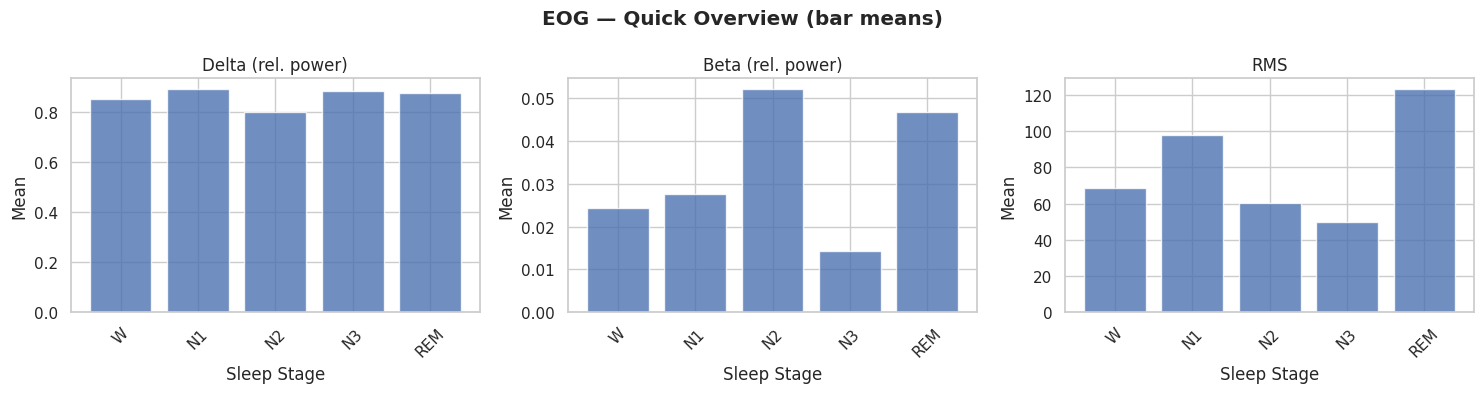

### Stage Discrimination (Kruskal H and η²) — EOG

feature,H,p,eta2,n
EOG_rms,185.689,4.47e-39,0.181,"1,007"
EOG_beta_relpow_256,138.646,5.5e-29,0.134,"1,007"
EOG_delta_relpow_256,121.509,2.54e-25,0.117,"1,007"


### Temporal Redundancy — Spearman(TSO, feature) — EOG

feature,spearman_rho,p_value
EOG_beta_relpow_256,0.190,1.34e-09
EOG_delta_relpow_256,-0.168,8.39e-08
EOG_rms,-0.116,0.000216


### Suggested EOG Features to Keep

feature
EOG_rms
EOG_beta_relpow_256
EOG_delta_relpow_256


**Clinical reading (rule-of-thumb):**

• REM: bursts/rapid eye movements; spectral entropy and SEF95 capture higher-frequency 'disorder'.
• NREM (N2/N3): generally calmer EOG, higher relative delta, lower RMS and entropy.
• Wake (W): more variable; potentially higher RMS and beta relative power — watch out for artifacts.
• Note: 'EOG_beta_relpow' alone is not always the best REM marker; entropy/SEF and burst dynamics help.

## EOG — Stage-wise Distributions and Feature Audit

### Stage-wise Means

,EOG_delta_relpow_256__mean,EOG_theta_relpow_256__mean,EOG_beta_relpow_256__mean,EOG_rms__mean,EOG_spec_entropy_256__mean,EOG_sef95_256__mean
stage,,,,,,
W,0.853,0.068,0.024,68.837,0.521,9.695
N1,0.890,0.046,0.028,98.182,0.439,9.233
N2,0.799,0.072,0.052,60.214,0.560,13.845
N3,0.884,0.063,0.014,49.829,0.489,7.440
REM,0.875,0.037,0.047,123.110,0.418,10.445


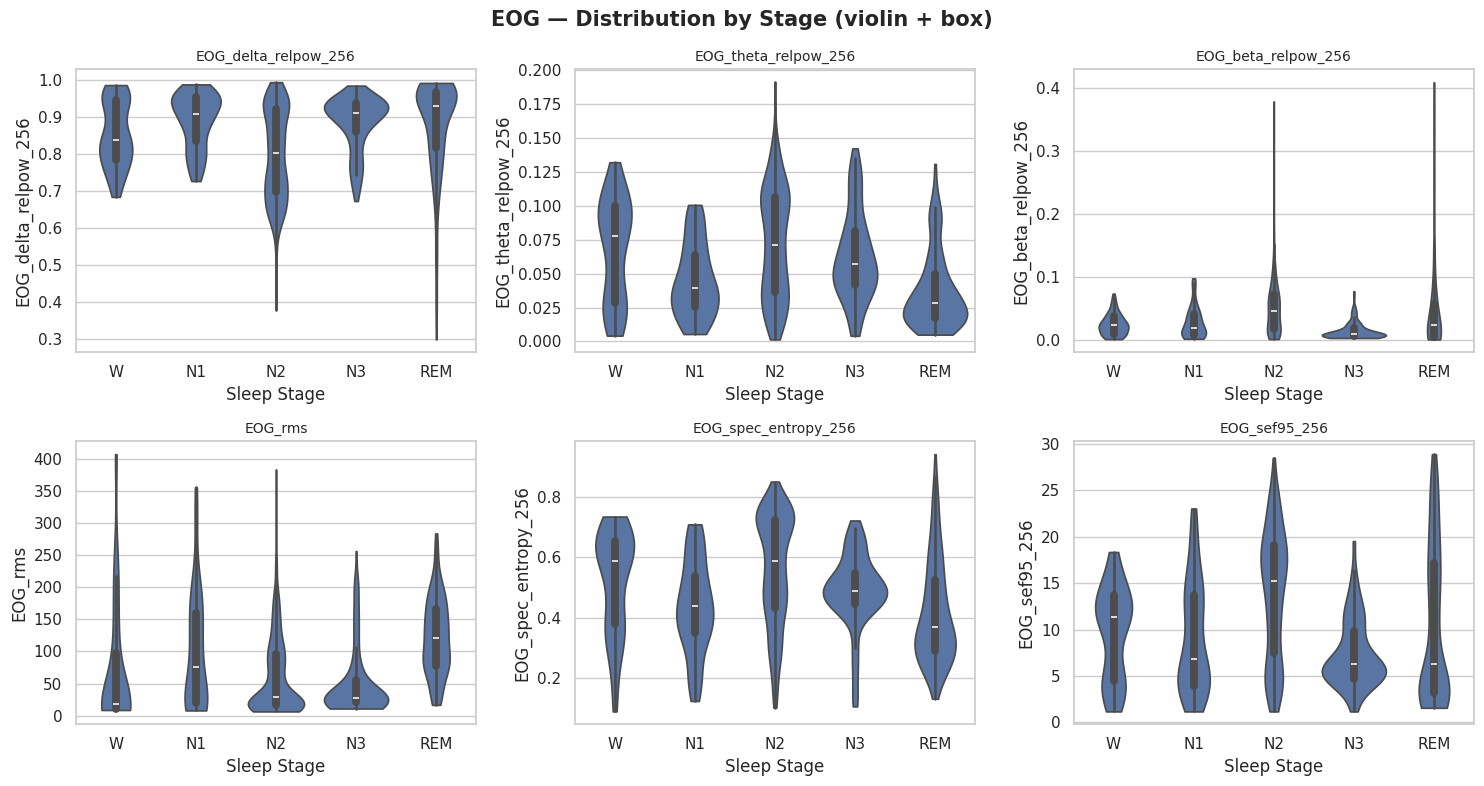

### Stage Discrimination (Kruskal H and η²) — EOG

feature,H,p,eta2,n
EOG_rms,185.689,4.47e-39,0.181,"1,007"
EOG_theta_relpow_256,140.978,1.74e-29,0.137,"1,007"
EOG_beta_relpow_256,138.646,5.5e-29,0.134,"1,007"
EOG_delta_relpow_256,121.509,2.54e-25,0.117,"1,007"
EOG_spec_entropy_256,120.692,3.8e-25,0.116,"1,007"
EOG_sef95_256,110.042,7.13e-23,0.106,"1,007"


### Temporal Redundancy — Spearman(TSO, feature) — EOG

feature,spearman_rho,p_value
EOG_beta_relpow_256,0.190,1.34e-09
EOG_spec_entropy_256,0.168,8.31e-08
EOG_delta_relpow_256,-0.168,8.39e-08
EOG_sef95_256,0.154,9.7e-07
EOG_theta_relpow_256,0.138,1.07e-05
EOG_rms,-0.116,0.000216


### Suggested EOG Features to Keep

feature
EOG_rms
EOG_theta_relpow_256
EOG_beta_relpow_256
EOG_delta_relpow_256
EOG_spec_entropy_256
EOG_sef95_256


**Clinical reading (rule-of-thumb):**

• REM: bursts/rapid eye movements; spectral entropy and SEF95 capture higher-frequency 'disorder'.
• NREM (N2/N3): generally calmer EOG, higher relative delta, lower RMS and entropy.
• Wake (W): more variable; potentially higher RMS and beta relative power — watch out for artifacts.
• Note: 'EOG_beta_relpow' alone is not always the best REM marker; entropy/SEF and burst dynamics help.

In [27]:
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, spearmanr

def eog_panel(
    df,
    stage_col="stage",
    stage_order=("W","N1","N2","N3","REM"),
    mode="full",
    features_quick=("EOG_delta_relpow_256", "EOG_beta_relpow_256", "EOG_rms"),
    candidate_features_full=(
        "EOG_delta_relpow_256","EOG_theta_relpow_256","EOG_beta_relpow_256",
        "EOG_rms","EOG_spec_entropy_256","EOG_sef95_256"
    ),
    show_selection=True,
    eta_min=0.06, 
    rho_max=0.50, 
    lang="en"
):
    L = {
        "en": {
            "title_quick": "EOG — Quick Stage-wise Summary",
            "title_full": "EOG — Stage-wise Distributions and Feature Audit",
            "means_title": "Stage-wise Means",
            "means_caption": "Mean values of selected EOG features per sleep stage",
            "bars_title": "EOG — Quick Overview (bar means)",
            "violin_title": "EOG — Distribution by Stage (violin + box)",
            "kr_title": "Stage Discrimination (Kruskal H and η²) — EOG",
            "kr_caption": "Higher η² ⇒ stronger separation across sleep stages",
            "sp_title": "Temporal Redundancy — Spearman(TSO, feature) — EOG",
            "sel_title": "Suggested EOG Features to Keep",
            "clinical_title": "Clinical reading (rule-of-thumb)",
            "clinical_notes": [
                "REM: bursts/rapid eye movements; spectral entropy and SEF95 capture higher-frequency 'disorder'.",
                "NREM (N2/N3): generally calmer EOG, higher relative delta, lower RMS and entropy.",
                "Wake (W): more variable; potentially higher RMS and beta relative power — watch out for artifacts.",
                "Note: 'EOG_beta_relpow' alone is not always the best REM marker; entropy/SEF and burst dynamics help."
            ],
            "x_stage": "Sleep Stage",
            "y_value": "Value",
            "mean_label": "Mean",
            "no_feat": "> No matching EOG features found in the dataframe.",
            "tso_missing": "> `tso_min` not found — skipping Spearman temporal redundancy.",
        }
    }[lang]

    if mode == "quick":
        feats = [f for f in features_quick if f in df.columns]
    else:
        feats = [f for f in candidate_features_full if f in df.columns]

    if not feats:
        display(Markdown(L["no_feat"]))
        return

    cols_needed = [stage_col] + feats
    if "tso_min" in df.columns:
        cols_needed.append("tso_min")
    df_eog = df.select([c for c in cols_needed if c in df.columns]).drop_nulls()

    means = (
        df_eog.group_by(stage_col)
              .agg([pl.col(f).mean().alias(f"{f}__mean") for f in feats])
              .to_pandas()
              .set_index(stage_col)
              .reindex(stage_order)
    )

    display(Markdown(f"## {L['title_quick'] if mode=='quick' else L['title_full']}"))

    display(Markdown(f"### {L['means_title']}"))
    display(
        means.style
             .format("{:.3f}")
             .set_caption(L["means_caption"])
    )

    pdf = df_eog.to_pandas().copy()
    pdf[stage_col] = pd.Categorical(pdf[stage_col], categories=stage_order, ordered=True)

    if mode == "quick":
        disp_map = {
            "EOG_delta_relpow_256": "Delta (rel. power)",
            "EOG_beta_relpow_256": "Beta (rel. power)",
            "EOG_rms": "RMS"
        }
        fig, axes = plt.subplots(1, min(3, len(feats)), figsize=(5*min(3,len(feats)), 4))
        if not isinstance(axes, np.ndarray):
            axes = np.array([axes])
        data_means = means.reset_index().rename(columns={stage_col: "stage"})
        for i, f in enumerate(feats[:3]):
            ax = axes[i]
            ax.bar(data_means["stage"], data_means[f"{f}__mean"], alpha=0.8)
            ax.set_title(disp_map.get(f, f))
            ax.set_xlabel(L["x_stage"])
            ax.set_ylabel(L["mean_label"])
            ax.tick_params(axis='x', rotation=45)
        plt.suptitle(L["bars_title"], fontweight="bold")
        plt.tight_layout()
        plt.show()
    else:
        ncols = 3
        nrows = int(np.ceil(len(feats) / ncols))
        plt.figure(figsize=(5*ncols, 4*nrows))
        for i, feat in enumerate(feats, start=1):
            plt.subplot(nrows, ncols, i)
            sns.violinplot(data=pdf, x=stage_col, y=feat, order=stage_order, inner="box", cut=0)
            plt.title(feat, fontsize=10)
            plt.xlabel(L["x_stage"]); plt.ylabel(feat)
        plt.suptitle(L["violin_title"], fontsize=15, fontweight="bold")
        plt.tight_layout()
        plt.show()

    def kruskal_eta2(frame: pd.DataFrame, feature: str, classes: list[str]) -> dict:
        d = frame[[stage_col, feature]].dropna()
        groups = [d.loc[d[stage_col] == s, feature].values for s in classes]
        if any(len(g) < 2 for g in groups):
            return {"feature": feature, "H": np.nan, "p": np.nan, "eta2": np.nan, "n": len(d)}
        H, p = kruskal(*groups)
        n, k = len(d), len(classes)
        eta2 = (H - k + 1) / (n - k) if (n - k) > 0 else np.nan
        return {"feature": feature, "H": H, "p": p, "eta2": eta2, "n": n}

    kr_rows = [kruskal_eta2(pdf, f, list(stage_order)) for f in feats]
    kr_df = pd.DataFrame(kr_rows).sort_values(by="eta2", ascending=False).reset_index(drop=True)
    display(Markdown(f"### {L['kr_title']}"))
    display(
        kr_df.style
             .format({"H": "{:.3f}", "p": "{:.3g}", "eta2": "{:.3f}", "n": "{:,.0f}"})
             .set_caption(L["kr_caption"])
             .hide(axis="index")
    )

    if "tso_min" in pdf.columns:
        sp_rows = []
        for f in feats:
            d = pdf[["tso_min", f]].dropna()
            if len(d) > 3:
                rho, p = spearmanr(d["tso_min"], d[f])
                sp_rows.append({"feature": f, "spearman_rho": rho, "p_value": p})
        sp_df = pd.DataFrame(sp_rows).sort_values(by="spearman_rho", key=lambda s: s.abs(), ascending=False).reset_index(drop=True)
        display(Markdown(f"### {L['sp_title']}"))
        display(
            sp_df.style
                .format({"spearman_rho": "{:.3f}", "p_value": "{:.3g}"})
                .hide(axis="index")
        )
    else:
        display(Markdown(L["tso_missing"]))
        sp_df = pd.DataFrame(columns=["feature","spearman_rho","p_value"])

    if show_selection:
        rho_map = {r["feature"]: r["spearman_rho"] for _, r in sp_df.iterrows()} if not sp_df.empty else {}
        keep = []
        for _, r in kr_df.iterrows():
            f = r["feature"]
            if pd.isna(r["eta2"]) or f not in feats: 
                continue
            rho = abs(rho_map.get(f, 0.0))
            if r["eta2"] >= eta_min and rho <= rho_max:
                keep.append(f)
        display(Markdown(f"### {L['sel_title']}"))
        if keep:
            display(pd.DataFrame({"feature": keep}).style.hide(axis="index"))
        else:
            display(Markdown("> No features met the selection criteria."))

    display(Markdown(f"**{L['clinical_title']}:**"))
    display(Markdown("• " + "\n• ".join(L["clinical_notes"])))
    
eog_panel(df, mode="quick", stage_order=stage_order, lang="en")

eog_panel(df, mode="full", stage_order=stage_order, lang="en")


## EMG — Quick Stage-wise Summary

### Stage-wise Means

,EMG_submental_rms_1hz__mean,EMG_submental_p90_1hz__mean,EMG_submental_iqr_1hz__mean
stage,,,
W,27.611,40.851,17.286
N1,78.193,116.392,45.575
N2,42.267,64.988,28.803
N3,98.607,158.564,65.663
REM,35.657,55.625,23.330


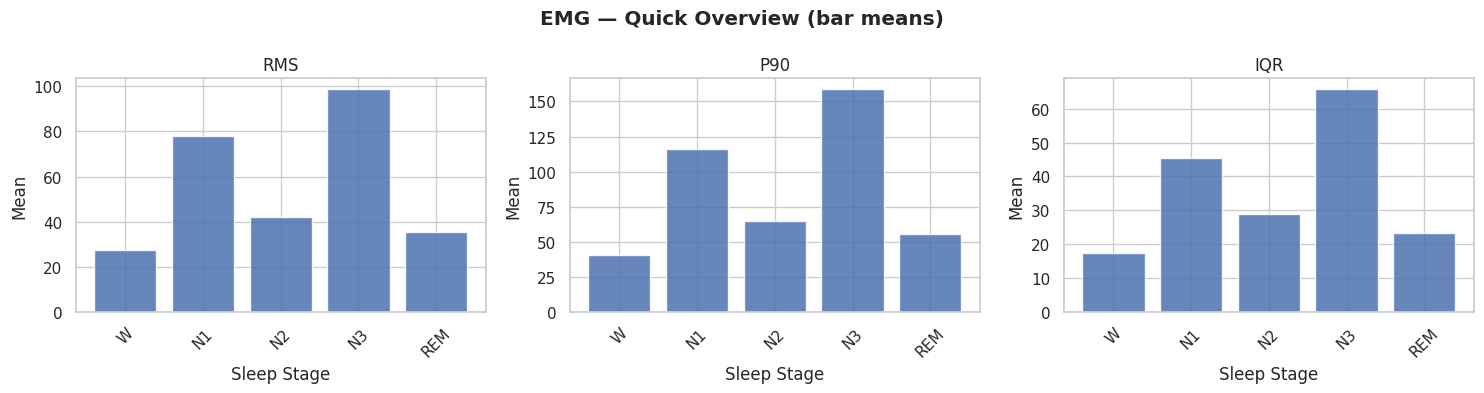

### Stage Discrimination (Kruskal H and η²) — EMG

feature,H,p,eta2,n
EMG_submental_rms_1hz,133.814,5.95e-28,0.130,"1,007"
EMG_submental_p90_1hz,131.187,2.17e-27,0.127,"1,007"
EMG_submental_iqr_1hz,118.228,1.28e-24,0.114,"1,007"


### Temporal Redundancy — Spearman(TSO, feature) — EMG

feature,spearman_rho,p_value
EMG_submental_rms_1hz,-0.354,4.6e-31
EMG_submental_p90_1hz,-0.344,2.37e-29
EMG_submental_iqr_1hz,-0.288,1.16e-20


### Suggested EMG Features to Keep

feature
EMG_submental_rms_1hz
EMG_submental_p90_1hz
EMG_submental_iqr_1hz


**Clinical reading (rule-of-thumb):**

• Wake (W): higher chin EMG tone → RMS/p90 elevados.
• REM: atonia característica → RMS/median/p90 baixos (picos transitórios podem ocorrer).
• N2/N3: EMG baixo e estável; variabilidade (IQR/MAD/diffRMS) tende a cair.
• Slope ao longo da noite pode capturar drift; use com cautela (risco de vazamento temporal).

## EMG — Stage-wise Distributions and Feature Audit

### Stage-wise Means

,EMG_submental_rms_1hz__mean,EMG_submental_median_1hz__mean,EMG_submental_mean_1hz__mean,EMG_submental_p90_1hz__mean,EMG_submental_p10_1hz__mean,EMG_submental_iqr_1hz__mean,EMG_submental_mad_1hz__mean,EMG_submental_std_1hz__mean,EMG_submental_diff_rms_1hz__mean,EMG_submental_slope_1hz__mean,EMG_submental_skewness_1hz__mean,EMG_submental_kurtosis_1hz__mean
stage,,,,,,,,,,,,
W,27.611,20.040,23.220,40.851,9.070,17.286,8.423,14.406,14.149,-0.109,1.138,1.275
N1,78.193,51.290,63.261,116.392,18.032,45.575,16.258,42.494,35.271,-0.035,1.019,1.374
N2,42.267,26.201,33.523,64.988,11.012,28.803,11.864,24.334,19.652,-0.025,0.959,0.927
N3,98.607,55.665,74.982,158.564,21.333,65.663,26.729,60.302,45.210,-0.048,1.038,1.181
REM,35.657,24.106,28.988,55.625,9.643,23.330,9.778,19.510,13.087,-0.060,0.877,0.756


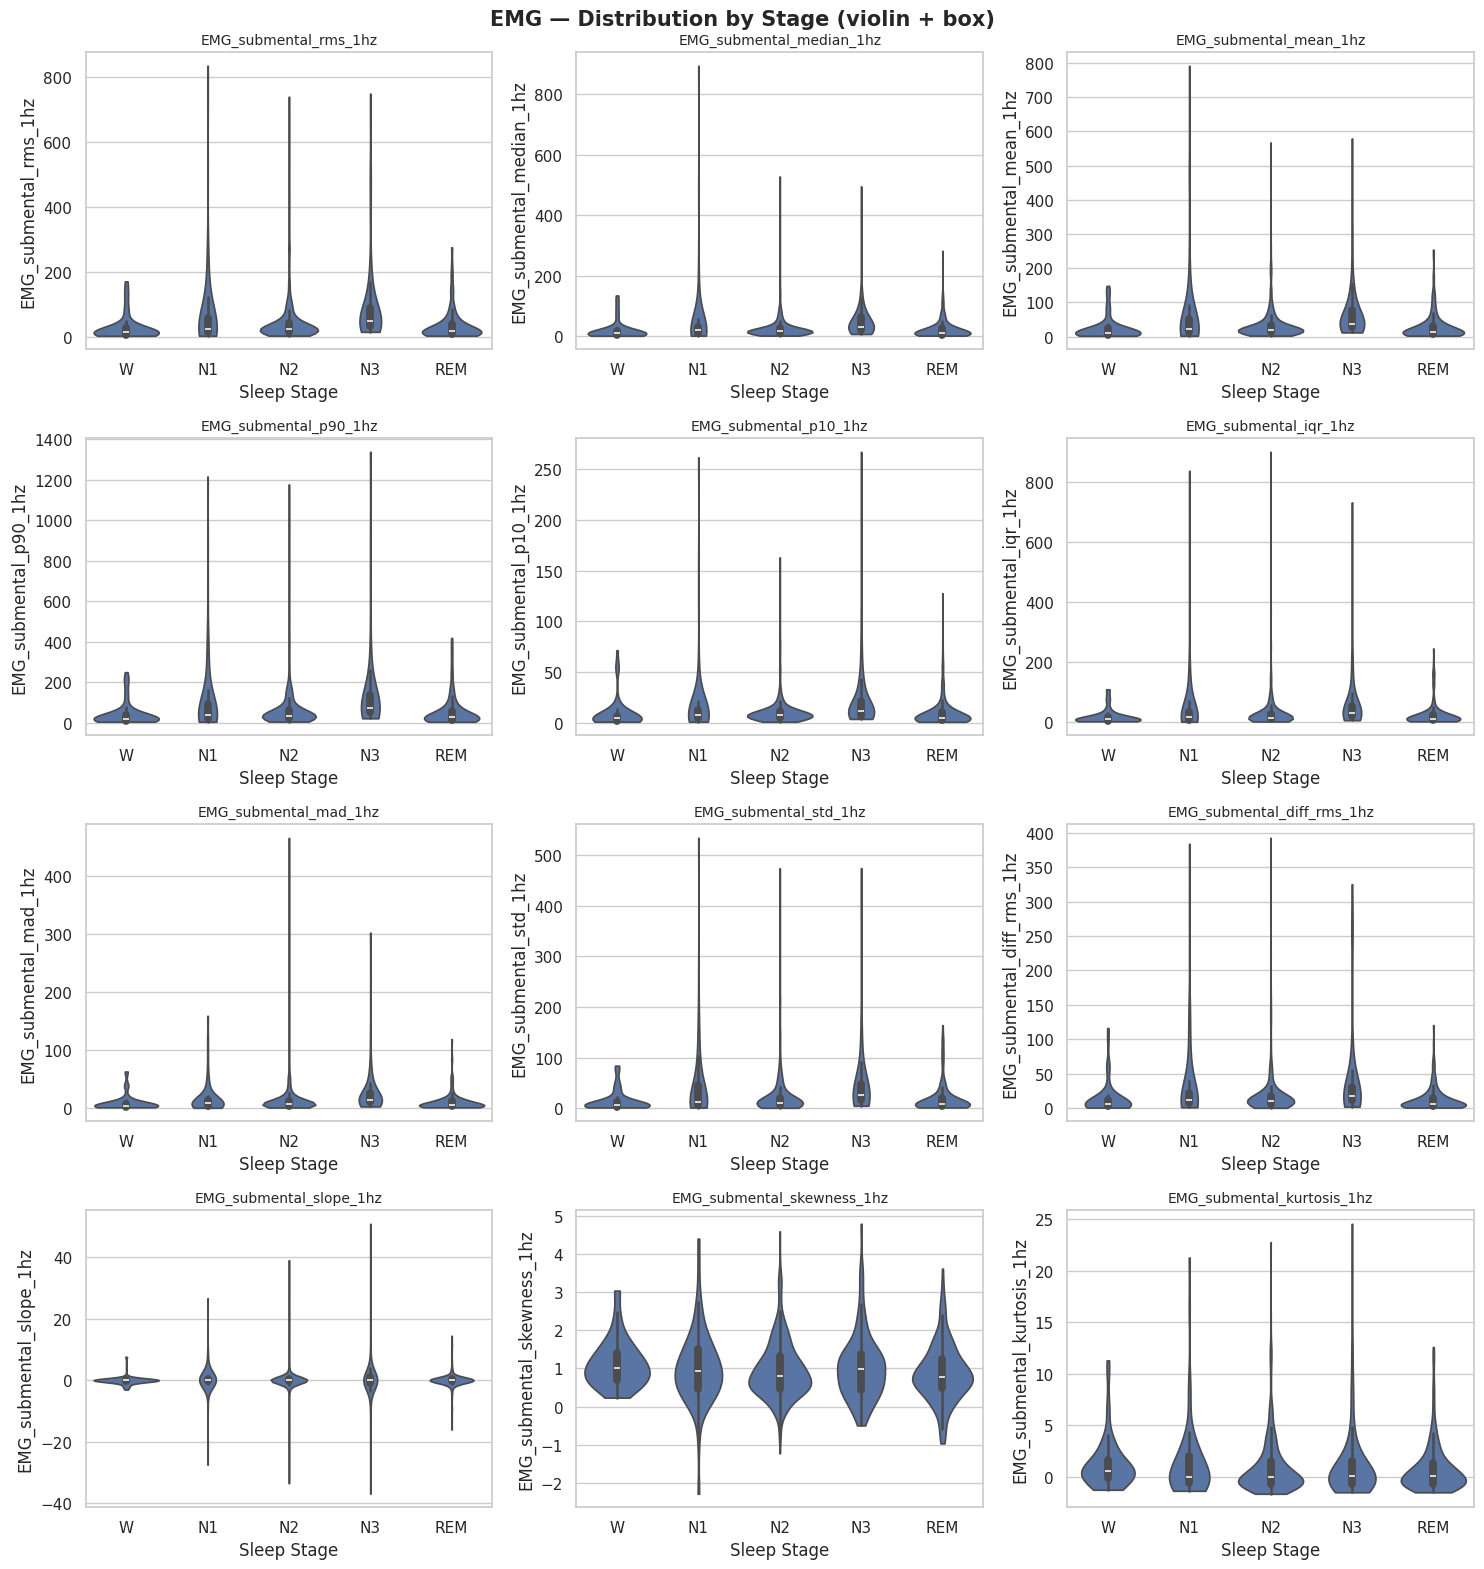

### Stage Discrimination (Kruskal H and η²) — EMG

feature,H,p,eta2,n
EMG_submental_rms_1hz,133.814,5.95e-28,0.130,"1,007"
EMG_submental_mean_1hz,133.634,6.5e-28,0.129,"1,007"
EMG_submental_p90_1hz,131.187,2.17e-27,0.127,"1,007"
EMG_submental_std_1hz,121.584,2.45e-25,0.117,"1,007"
EMG_submental_median_1hz,118.682,1.02e-24,0.114,"1,007"
EMG_submental_iqr_1hz,118.228,1.28e-24,0.114,"1,007"
EMG_submental_mad_1hz,113.777,1.14e-23,0.110,"1,007"
EMG_submental_p10_1hz,102.460,2.94e-21,0.098,"1,007"
EMG_submental_diff_rms_1hz,96.712,4.93e-20,0.093,"1,007"
EMG_submental_skewness_1hz,7.683,0.104,0.004,"1,007"


### Temporal Redundancy — Spearman(TSO, feature) — EMG

feature,spearman_rho,p_value
EMG_submental_rms_1hz,-0.354,4.6e-31
EMG_submental_mean_1hz,-0.348,4.5e-30
EMG_submental_p90_1hz,-0.344,2.37e-29
EMG_submental_std_1hz,-0.340,1.27e-28
EMG_submental_p10_1hz,-0.311,4.4e-24
EMG_submental_median_1hz,-0.311,5.78e-24
EMG_submental_iqr_1hz,-0.288,1.16e-20
EMG_submental_mad_1hz,-0.267,5.95e-18
EMG_submental_diff_rms_1hz,-0.260,4.79e-17
EMG_submental_skewness_1hz,-0.151,1.39e-06


### Suggested EMG Features to Keep

feature
EMG_submental_rms_1hz
EMG_submental_mean_1hz
EMG_submental_p90_1hz
EMG_submental_std_1hz
EMG_submental_median_1hz
EMG_submental_iqr_1hz
EMG_submental_mad_1hz
EMG_submental_p10_1hz
EMG_submental_diff_rms_1hz


**Clinical reading (rule-of-thumb):**

• Wake (W): higher chin EMG tone → RMS/p90 elevados.
• REM: atonia característica → RMS/median/p90 baixos (picos transitórios podem ocorrer).
• N2/N3: EMG baixo e estável; variabilidade (IQR/MAD/diffRMS) tende a cair.
• Slope ao longo da noite pode capturar drift; use com cautela (risco de vazamento temporal).

In [28]:
def emg_panel(
    df,
    stage_col="stage",
    stage_order=("W","N1","N2","N3","REM"),
    mode="full",
    features_quick=("EMG_submental_rms_1hz",
                    "EMG_submental_p90_1hz",
                    "EMG_submental_iqr_1hz"),
    candidate_features_full=(
        "EMG_submental_rms_1hz",
        "EMG_submental_median_1hz",
        "EMG_submental_mean_1hz",
        "EMG_submental_p90_1hz",
        "EMG_submental_p10_1hz",
        "EMG_submental_iqr_1hz",
        "EMG_submental_mad_1hz",
        "EMG_submental_std_1hz",
        "EMG_submental_diff_rms_1hz",
        "EMG_submental_slope_1hz",    
        "EMG_submental_skewness_1hz",
        "EMG_submental_kurtosis_1hz",
    ),
    show_selection=True,
    eta_min=0.06,     
    rho_max=0.50,  
    lang="en"
):
    L = {
        "en": {
            "title_quick": "EMG — Quick Stage-wise Summary",
            "title_full": "EMG — Stage-wise Distributions and Feature Audit",
            "means_title": "Stage-wise Means",
            "means_caption": "Mean values of selected EMG features per sleep stage",
            "bars_title": "EMG — Quick Overview (bar means)",
            "violin_title": "EMG — Distribution by Stage (violin + box)",
            "kr_title": "Stage Discrimination (Kruskal H and η²) — EMG",
            "kr_caption": "Higher η² ⇒ stronger separation across sleep stages",
            "sp_title": "Temporal Redundancy — Spearman(TSO, feature) — EMG",
            "sel_title": "Suggested EMG Features to Keep",
            "clinical_title": "Clinical reading (rule-of-thumb)",
            "clinical_notes": [
                "Wake (W): higher chin EMG tone → RMS/p90 elevados.",
                "REM: atonia característica → RMS/median/p90 baixos (picos transitórios podem ocorrer).",
                "N2/N3: EMG baixo e estável; variabilidade (IQR/MAD/diffRMS) tende a cair.",
                "Slope ao longo da noite pode capturar drift; use com cautela (risco de vazamento temporal)."
            ],
            "x_stage": "Sleep Stage",
            "y_value": "Value",
            "mean_label": "Mean",
            "no_feat": "> No matching EMG features found in the dataframe.",
            "tso_missing": "> `tso_min` not found — skipping Spearman temporal redundancy.",
        }
    }[lang]

    feats = [f for f in (features_quick if mode=="quick" else candidate_features_full) if f in df.columns]
    if not feats:
        display(Markdown(L["no_feat"]))
        return

    cols_needed = [stage_col] + feats + (["tso_min"] if "tso_min" in df.columns else [])
    df_emg = df.select([c for c in cols_needed if c in df.columns]).drop_nulls()

    means = (
        df_emg.group_by(stage_col)
              .agg([pl.col(f).mean().alias(f"{f}__mean") for f in feats])
              .to_pandas()
              .set_index(stage_col)
              .reindex(stage_order)
    )

    display(Markdown(f"## {L['title_quick'] if mode=='quick' else L['title_full']}"))
    display(Markdown(f"### {L['means_title']}"))
    display(means.style.format("{:.3f}").set_caption(L["means_caption"]))

    pdf = df_emg.to_pandas().copy()
    pdf[stage_col] = pd.Categorical(pdf[stage_col], categories=stage_order, ordered=True)

    if mode == "quick":
        disp_map = {
            "EMG_submental_rms_1hz": "RMS",
            "EMG_submental_p90_1hz": "P90",
            "EMG_submental_iqr_1hz": "IQR",
            "EMG_submental_median_1hz": "Median",
            "EMG_submental_mean_1hz": "Mean",
        }
        k = min(3, len(feats))
        fig, axes = plt.subplots(1, k, figsize=(5*k, 4))
        if not isinstance(axes, np.ndarray):
            axes = np.array([axes])
        data_means = means.reset_index().rename(columns={stage_col: "stage"})
        for i, f in enumerate(feats[:k]):
            ax = axes[i]
            ax.bar(data_means["stage"], data_means[f"{f}__mean"], alpha=0.85)
            ax.set_title(disp_map.get(f, f))
            ax.set_xlabel(L["x_stage"]); ax.set_ylabel(L["mean_label"])
            ax.tick_params(axis='x', rotation=45)
        plt.suptitle(L["bars_title"], fontweight="bold")
        plt.tight_layout(); plt.show()
    else:
        ncols = 3
        nrows = int(np.ceil(len(feats) / ncols))
        plt.figure(figsize=(5*ncols, 4*nrows))
        for i, feat in enumerate(feats, start=1):
            plt.subplot(nrows, ncols, i)
            sns.violinplot(data=pdf, x=stage_col, y=feat, order=stage_order, inner="box", cut=0)
            plt.title(feat, fontsize=10)
            plt.xlabel(L["x_stage"]); plt.ylabel(feat)
        plt.suptitle(L["violin_title"], fontsize=15, fontweight="bold")
        plt.tight_layout(); plt.show()

    def kruskal_eta2(frame: pd.DataFrame, feature: str, classes: list[str]) -> dict:
        d = frame[[stage_col, feature]].dropna()
        groups = [d.loc[d[stage_col] == s, feature].values for s in classes]
        if any(len(g) < 2 for g in groups):
            return {"feature": feature, "H": np.nan, "p": np.nan, "eta2": np.nan, "n": len(d)}
        H, p = kruskal(*groups)
        n, k = len(d), len(classes)
        eta2 = (H - k + 1) / (n - k) if (n - k) > 0 else np.nan
        return {"feature": feature, "H": H, "p": p, "eta2": eta2, "n": n}

    kr_rows = [kruskal_eta2(pdf, f, list(stage_order)) for f in feats]
    kr_df = pd.DataFrame(kr_rows).sort_values(by="eta2", ascending=False).reset_index(drop=True)

    display(Markdown(f"### {L['kr_title']}"))
    display(
        kr_df.style
            .format({"H": "{:.3f}", "p": "{:.3g}", "eta2": "{:.3f}", "n": "{:,.0f}"})
            .set_caption(L["kr_caption"])
            .hide(axis="index")
    )

    if "tso_min" in pdf.columns:
        sp_rows = []
        for f in feats:
            d = pdf[["tso_min", f]].dropna()
            if len(d) > 3:
                rho, p = spearmanr(d["tso_min"], d[f])
                sp_rows.append({"feature": f, "spearman_rho": rho, "p_value": p})
        sp_df = pd.DataFrame(sp_rows).sort_values(by="spearman_rho", key=lambda s: s.abs(), ascending=False).reset_index(drop=True)
        display(Markdown(f"### {L['sp_title']}"))
        display(sp_df.style.format({"spearman_rho": "{:.3f}", "p_value": "{:.3g}"}).hide(axis="index"))
    else:
        display(Markdown(L["tso_missing"]))
        sp_df = pd.DataFrame(columns=["feature","spearman_rho","p_value"])

    if show_selection:
        rho_map = {r["feature"]: r["spearman_rho"] for _, r in sp_df.iterrows()} if not sp_df.empty else {}
        keep = []
        for _, r in kr_df.iterrows():
            f = r["feature"]
            if pd.isna(r["eta2"]) or f not in feats: 
                continue
            rho = abs(rho_map.get(f, 0.0))
            if r["eta2"] >= eta_min and rho <= rho_max:
                keep.append(f)
        display(Markdown(f"### {L['sel_title']}"))
        if keep:
            display(pd.DataFrame({"feature": keep}).style.hide(axis="index"))
        else:
            display(Markdown("> No features met the selection criteria."))

    display(Markdown(f"**{L['clinical_title']}:**"))
    display(Markdown("• " + "\n• ".join(L["clinical_notes"])))

emg_panel(df, mode="quick", stage_order=("W","N1","N2","N3","REM"), lang="en")
emg_panel(df, mode="full",  stage_order=("W","N1","N2","N3","REM"), lang="en")

### 4.3 Auxiliary Physiological Signals

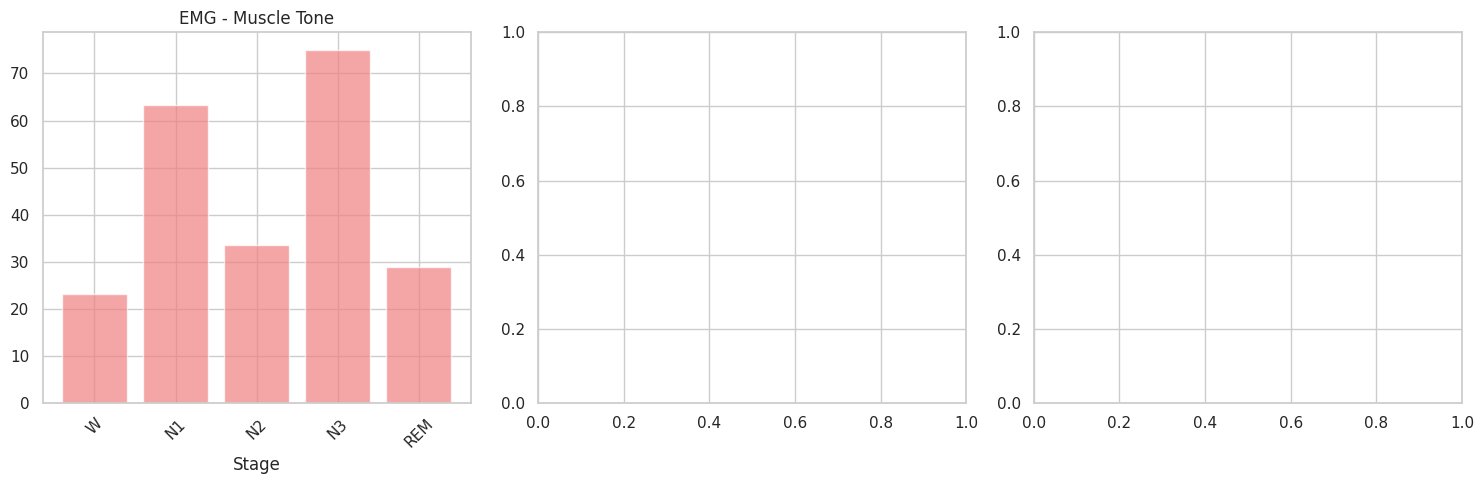

=== PHYSIOLOGICAL INTERPRETATION ===
• EMG: Highest during wakefulness, lowest during REM (muscle atonia)


In [29]:
physio_features = {
    'EMG (Muscle Tone)': 'EMG_submental_mean_1hz'
}

physio_stats = df.group_by("stage").agg([
    pl.col(feature).mean().alias(name.split(' ')[0].lower())
    for name, feature in physio_features.items()
])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['emg']
titles = ['EMG - Muscle Tone']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    data = physio_stats.to_pandas().set_index('stage').reindex(stage_order)
    
    axes[i].bar(data.index, data[metric], color='lightcoral', alpha=0.7)
    axes[i].set_title(title)
    axes[i].set_xlabel('Stage')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("=== PHYSIOLOGICAL INTERPRETATION ===")
print("• EMG: Highest during wakefulness, lowest during REM (muscle atonia)")

## EMG — Quick Stage-wise Summary

### Stage-wise Means

,EMG_submental_rms_1hz__mean,EMG_submental_p90_1hz__mean,EMG_submental_iqr_1hz__mean
stage,,,
W,27.611,40.851,17.286
N1,78.193,116.392,45.575
N2,42.267,64.988,28.803
N3,98.607,158.564,65.663
REM,35.657,55.625,23.330


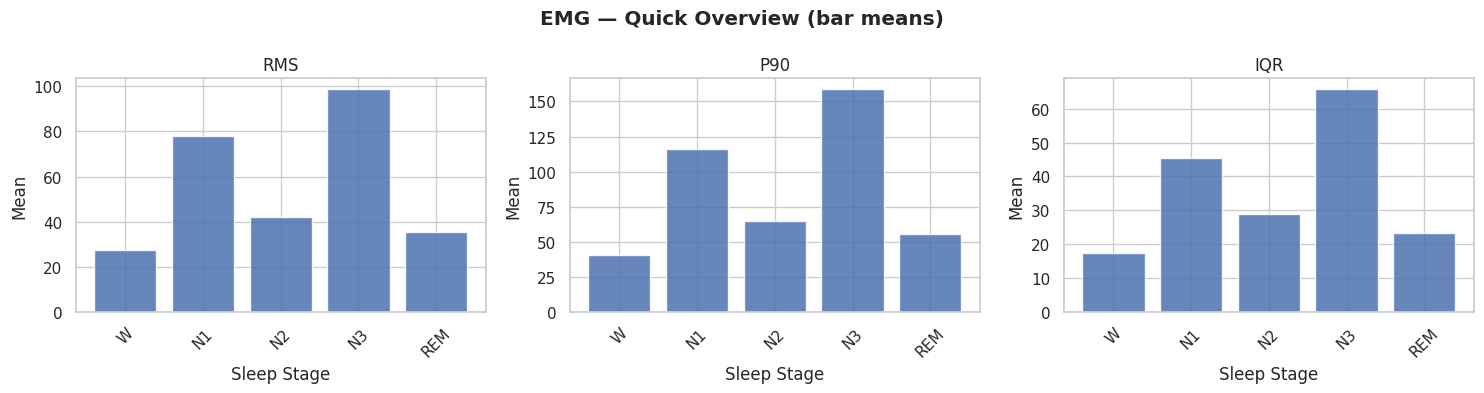

### Stage Discrimination (Kruskal H and η²) — EMG

feature,H,p,eta2,n
EMG_submental_rms_1hz,133.814,5.95e-28,0.130,"1,007"
EMG_submental_p90_1hz,131.187,2.17e-27,0.127,"1,007"
EMG_submental_iqr_1hz,118.228,1.28e-24,0.114,"1,007"


### Temporal Redundancy — Spearman(TSO, feature) — EMG

feature,spearman_rho,p_value
EMG_submental_rms_1hz,-0.354,4.6e-31
EMG_submental_p90_1hz,-0.344,2.37e-29
EMG_submental_iqr_1hz,-0.288,1.16e-20


### Suggested EMG Features to Keep

feature
EMG_submental_rms_1hz
EMG_submental_p90_1hz
EMG_submental_iqr_1hz


**Clinical reading (rule-of-thumb):**

• Wake (W): higher chin EMG tone → RMS/p90 elevados.
• REM: atonia característica → RMS/median/p90 baixos (picos transitórios podem ocorrer).
• N2/N3: EMG baixo e estável; variabilidade (IQR/MAD/diffRMS) tende a cair.
• Slope ao longo da noite pode capturar drift; use com cautela (risco de vazamento temporal).

## EMG — Stage-wise Distributions and Feature Audit

### Stage-wise Means

,EMG_submental_rms_1hz__mean,EMG_submental_median_1hz__mean,EMG_submental_mean_1hz__mean,EMG_submental_p90_1hz__mean,EMG_submental_p10_1hz__mean,EMG_submental_iqr_1hz__mean,EMG_submental_mad_1hz__mean,EMG_submental_std_1hz__mean,EMG_submental_diff_rms_1hz__mean,EMG_submental_slope_1hz__mean,EMG_submental_skewness_1hz__mean,EMG_submental_kurtosis_1hz__mean
stage,,,,,,,,,,,,
W,27.611,20.040,23.220,40.851,9.070,17.286,8.423,14.406,14.149,-0.109,1.138,1.275
N1,78.193,51.290,63.261,116.392,18.032,45.575,16.258,42.494,35.271,-0.035,1.019,1.374
N2,42.267,26.201,33.523,64.988,11.012,28.803,11.864,24.334,19.652,-0.025,0.959,0.927
N3,98.607,55.665,74.982,158.564,21.333,65.663,26.729,60.302,45.210,-0.048,1.038,1.181
REM,35.657,24.106,28.988,55.625,9.643,23.330,9.778,19.510,13.087,-0.060,0.877,0.756


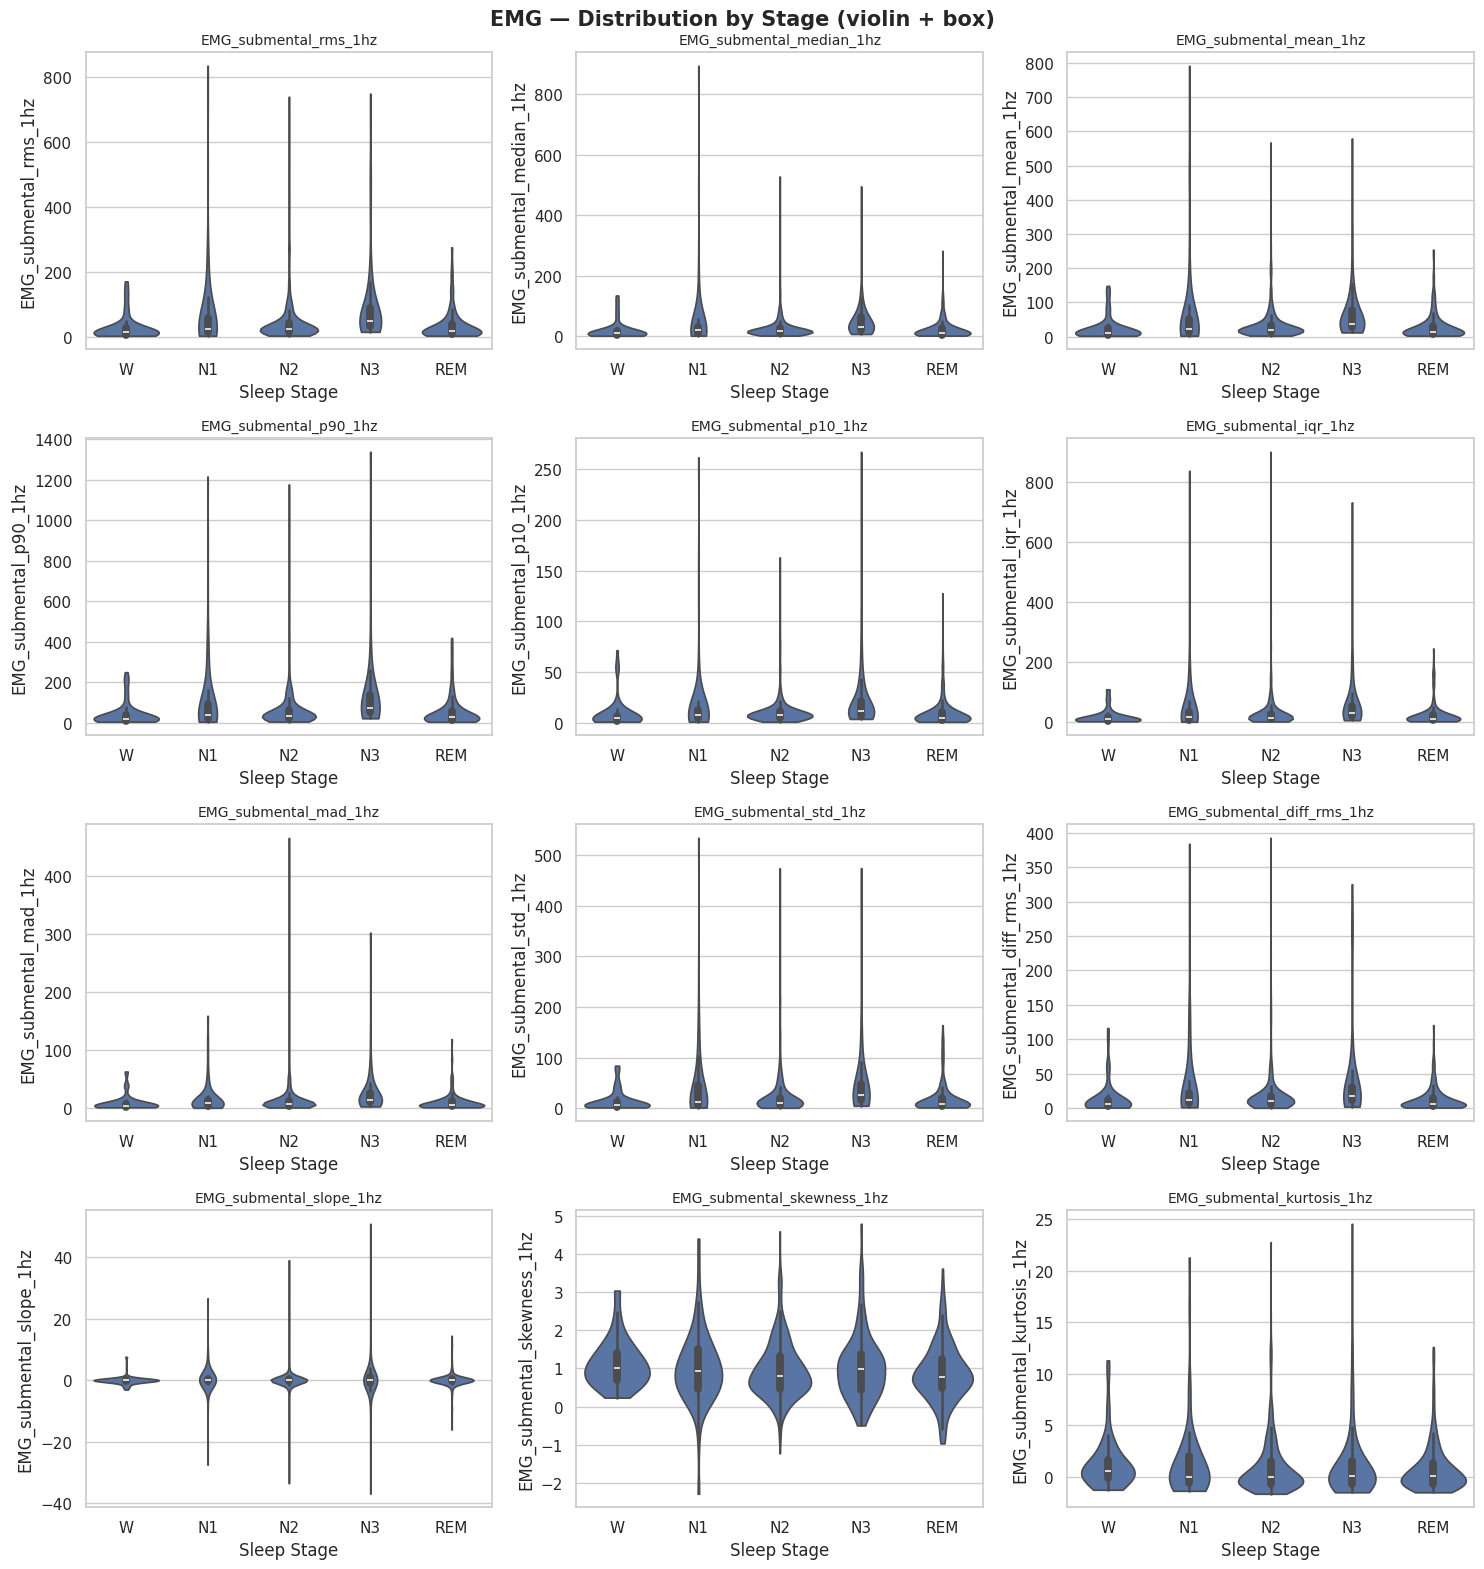

### Stage Discrimination (Kruskal H and η²) — EMG

feature,H,p,eta2,n
EMG_submental_rms_1hz,133.814,5.95e-28,0.130,"1,007"
EMG_submental_mean_1hz,133.634,6.5e-28,0.129,"1,007"
EMG_submental_p90_1hz,131.187,2.17e-27,0.127,"1,007"
EMG_submental_std_1hz,121.584,2.45e-25,0.117,"1,007"
EMG_submental_median_1hz,118.682,1.02e-24,0.114,"1,007"
EMG_submental_iqr_1hz,118.228,1.28e-24,0.114,"1,007"
EMG_submental_mad_1hz,113.777,1.14e-23,0.110,"1,007"
EMG_submental_p10_1hz,102.460,2.94e-21,0.098,"1,007"
EMG_submental_diff_rms_1hz,96.712,4.93e-20,0.093,"1,007"
EMG_submental_skewness_1hz,7.683,0.104,0.004,"1,007"


### Temporal Redundancy — Spearman(TSO, feature) — EMG

feature,spearman_rho,p_value
EMG_submental_rms_1hz,-0.354,4.6e-31
EMG_submental_mean_1hz,-0.348,4.5e-30
EMG_submental_p90_1hz,-0.344,2.37e-29
EMG_submental_std_1hz,-0.340,1.27e-28
EMG_submental_p10_1hz,-0.311,4.4e-24
EMG_submental_median_1hz,-0.311,5.78e-24
EMG_submental_iqr_1hz,-0.288,1.16e-20
EMG_submental_mad_1hz,-0.267,5.95e-18
EMG_submental_diff_rms_1hz,-0.260,4.79e-17
EMG_submental_skewness_1hz,-0.151,1.39e-06


### Suggested EMG Features to Keep

feature
EMG_submental_rms_1hz
EMG_submental_mean_1hz
EMG_submental_p90_1hz
EMG_submental_std_1hz
EMG_submental_median_1hz
EMG_submental_iqr_1hz
EMG_submental_mad_1hz
EMG_submental_p10_1hz
EMG_submental_diff_rms_1hz


**Clinical reading (rule-of-thumb):**

• Wake (W): higher chin EMG tone → RMS/p90 elevados.
• REM: atonia característica → RMS/median/p90 baixos (picos transitórios podem ocorrer).
• N2/N3: EMG baixo e estável; variabilidade (IQR/MAD/diffRMS) tende a cair.
• Slope ao longo da noite pode capturar drift; use com cautela (risco de vazamento temporal).

In [30]:
def emg_panel(
    df,
    stage_col="stage",
    stage_order=("W","N1","N2","N3","REM"),
    mode="full",
    features_quick=("EMG_submental_rms_1hz",
                    "EMG_submental_p90_1hz",
                    "EMG_submental_iqr_1hz"),
    candidate_features_full=(
        "EMG_submental_rms_1hz",
        "EMG_submental_median_1hz",
        "EMG_submental_mean_1hz",
        "EMG_submental_p90_1hz",
        "EMG_submental_p10_1hz",
        "EMG_submental_iqr_1hz",
        "EMG_submental_mad_1hz",
        "EMG_submental_std_1hz",
        "EMG_submental_diff_rms_1hz",
        "EMG_submental_slope_1hz",    
        "EMG_submental_skewness_1hz",
        "EMG_submental_kurtosis_1hz",
    ),
    show_selection=True,
    eta_min=0.06,     
    rho_max=0.50,  
    lang="en"
):
    L = {
        "en": {
            "title_quick": "EMG — Quick Stage-wise Summary",
            "title_full": "EMG — Stage-wise Distributions and Feature Audit",
            "means_title": "Stage-wise Means",
            "means_caption": "Mean values of selected EMG features per sleep stage",
            "bars_title": "EMG — Quick Overview (bar means)",
            "violin_title": "EMG — Distribution by Stage (violin + box)",
            "kr_title": "Stage Discrimination (Kruskal H and η²) — EMG",
            "kr_caption": "Higher η² ⇒ stronger separation across sleep stages",
            "sp_title": "Temporal Redundancy — Spearman(TSO, feature) — EMG",
            "sel_title": "Suggested EMG Features to Keep",
            "clinical_title": "Clinical reading (rule-of-thumb)",
            "clinical_notes": [
                "Wake (W): higher chin EMG tone → RMS/p90 elevados.",
                "REM: atonia característica → RMS/median/p90 baixos (picos transitórios podem ocorrer).",
                "N2/N3: EMG baixo e estável; variabilidade (IQR/MAD/diffRMS) tende a cair.",
                "Slope ao longo da noite pode capturar drift; use com cautela (risco de vazamento temporal)."
            ],
            "x_stage": "Sleep Stage",
            "y_value": "Value",
            "mean_label": "Mean",
            "no_feat": "> No matching EMG features found in the dataframe.",
            "tso_missing": "> `tso_min` not found — skipping Spearman temporal redundancy.",
        }
    }[lang]

    feats = [f for f in (features_quick if mode=="quick" else candidate_features_full) if f in df.columns]
    if not feats:
        display(Markdown(L["no_feat"]))
        return

    cols_needed = [stage_col] + feats + (["tso_min"] if "tso_min" in df.columns else [])
    df_emg = df.select([c for c in cols_needed if c in df.columns]).drop_nulls()

    means = (
        df_emg.group_by(stage_col)
              .agg([pl.col(f).mean().alias(f"{f}__mean") for f in feats])
              .to_pandas()
              .set_index(stage_col)
              .reindex(stage_order)
    )

    display(Markdown(f"## {L['title_quick'] if mode=='quick' else L['title_full']}"))
    display(Markdown(f"### {L['means_title']}"))
    display(means.style.format("{:.3f}").set_caption(L["means_caption"]))

    pdf = df_emg.to_pandas().copy()
    pdf[stage_col] = pd.Categorical(pdf[stage_col], categories=stage_order, ordered=True)

    if mode == "quick":
        disp_map = {
            "EMG_submental_rms_1hz": "RMS",
            "EMG_submental_p90_1hz": "P90",
            "EMG_submental_iqr_1hz": "IQR",
            "EMG_submental_median_1hz": "Median",
            "EMG_submental_mean_1hz": "Mean",
        }
        k = min(3, len(feats))
        fig, axes = plt.subplots(1, k, figsize=(5*k, 4))
        if not isinstance(axes, np.ndarray):
            axes = np.array([axes])
        data_means = means.reset_index().rename(columns={stage_col: "stage"})
        for i, f in enumerate(feats[:k]):
            ax = axes[i]
            ax.bar(data_means["stage"], data_means[f"{f}__mean"], alpha=0.85)
            ax.set_title(disp_map.get(f, f))
            ax.set_xlabel(L["x_stage"]); ax.set_ylabel(L["mean_label"])
            ax.tick_params(axis='x', rotation=45)
        plt.suptitle(L["bars_title"], fontweight="bold")
        plt.tight_layout(); plt.show()
    else:
        ncols = 3
        nrows = int(np.ceil(len(feats) / ncols))
        plt.figure(figsize=(5*ncols, 4*nrows))
        for i, feat in enumerate(feats, start=1):
            plt.subplot(nrows, ncols, i)
            sns.violinplot(data=pdf, x=stage_col, y=feat, order=stage_order, inner="box", cut=0)
            plt.title(feat, fontsize=10)
            plt.xlabel(L["x_stage"]); plt.ylabel(feat)
        plt.suptitle(L["violin_title"], fontsize=15, fontweight="bold")
        plt.tight_layout(); plt.show()

    def kruskal_eta2(frame: pd.DataFrame, feature: str, classes: list[str]) -> dict:
        d = frame[[stage_col, feature]].dropna()
        groups = [d.loc[d[stage_col] == s, feature].values for s in classes]
        if any(len(g) < 2 for g in groups):
            return {"feature": feature, "H": np.nan, "p": np.nan, "eta2": np.nan, "n": len(d)}
        H, p = kruskal(*groups)
        n, k = len(d), len(classes)
        eta2 = (H - k + 1) / (n - k) if (n - k) > 0 else np.nan
        return {"feature": feature, "H": H, "p": p, "eta2": eta2, "n": n}

    kr_rows = [kruskal_eta2(pdf, f, list(stage_order)) for f in feats]
    kr_df = pd.DataFrame(kr_rows).sort_values(by="eta2", ascending=False).reset_index(drop=True)

    display(Markdown(f"### {L['kr_title']}"))
    display(
        kr_df.style
            .format({"H": "{:.3f}", "p": "{:.3g}", "eta2": "{:.3f}", "n": "{:,.0f}"})
            .set_caption(L["kr_caption"])
            .hide(axis="index")
    )

    if "tso_min" in pdf.columns:
        sp_rows = []
        for f in feats:
            d = pdf[["tso_min", f]].dropna()
            if len(d) > 3:
                rho, p = spearmanr(d["tso_min"], d[f])
                sp_rows.append({"feature": f, "spearman_rho": rho, "p_value": p})
        sp_df = pd.DataFrame(sp_rows).sort_values(by="spearman_rho", key=lambda s: s.abs(), ascending=False).reset_index(drop=True)
        display(Markdown(f"### {L['sp_title']}"))
        display(sp_df.style.format({"spearman_rho": "{:.3f}", "p_value": "{:.3g}"}).hide(axis="index"))
    else:
        display(Markdown(L["tso_missing"]))
        sp_df = pd.DataFrame(columns=["feature","spearman_rho","p_value"])

    if show_selection:
        rho_map = {r["feature"]: r["spearman_rho"] for _, r in sp_df.iterrows()} if not sp_df.empty else {}
        keep = []
        for _, r in kr_df.iterrows():
            f = r["feature"]
            if pd.isna(r["eta2"]) or f not in feats: 
                continue
            rho = abs(rho_map.get(f, 0.0))
            if r["eta2"] >= eta_min and rho <= rho_max:
                keep.append(f)
        display(Markdown(f"### {L['sel_title']}"))
        if keep:
            display(pd.DataFrame({"feature": keep}).style.hide(axis="index"))
        else:
            display(Markdown("> No features met the selection criteria."))

    display(Markdown(f"**{L['clinical_title']}:**"))
    display(Markdown("• " + "\n• ".join(L["clinical_notes"])))

emg_panel(df, mode="quick", stage_order=("W","N1","N2","N3","REM"), lang="en")
emg_panel(df, mode="full",  stage_order=("W","N1","N2","N3","REM"), lang="en")

## 5. Correlations between Features

### 5.1 Correlations of the Main EEG Features

In [ ]:
def unique(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

stage_order = ["W","N1","N2","N3","REM"]
NON_FEATURES = {"subject_id","night_id","epoch_idx","t0_sec","stage"} 
corr_min_abs = 0.30           
top_k_pairs  = 20        
cluster_thr  = 0.85            
vif_max_cols = 300             

display(Markdown(
"""
## Feature Redundancy & Collinearity Audit — Explained

**Goal.** Detect redundant features and collinearity to simplify models and improve stability.

**What you’ll see:**
1. **Feature selection & constants removal** — numeric columns minus identifiers; drop constants.
2. **Global correlations** — Pearson and Spearman across *all epochs*; list top-|r| pairs.
3. **Intra-stage correlations** — Spearman within each sleep stage; compute **inflation** = |ρ|_global − median(|ρ|_intra).
4. **Partial Spearman** *(if `tso_min` exists)* — control for time-in-night; list top pairs.
5. **VIF** (Variance Inflation Factor) — linear multicollinearity indicator; show top VIFs.
6. **Graph clustering** by |corr| ≥ threshold and **representatives** (lowest VIF per cluster).
7. **Heatmap** of representatives.

**Reading tips.**
- Big |ρ| in global but **small** intra-stage → may reflect **stage mix** rather than true linkage.
- Partial Spearman that **drops** vs. global suggests shared dependence on **TSO** (potential leak).
- Clusters reveal **families** of near-duplicates; keep **one representative** (lowest VIF).
"""
))

num_cols = [c for c in df.select(cs.numeric()).columns if c not in NON_FEATURES]
const_cols = [c for c in num_cols if df.select(pl.col(c).n_unique()).item() <= 1]
feat_cols  = [c for c in num_cols if c not in const_cols and c != "tso_min"]

display(Markdown("### 1) Feature set after removing constants"))
display(Markdown(
f"- **Numeric total:** {len(num_cols)}  \n"
f"- **Removed constants:** {len(const_cols)}  \n"
f"- **Remaining candidates (excl. `tso_min`):** {len(feat_cols)}"
))

cols_needed = ["stage"] + (["tso_min"] if "tso_min" in df.columns else []) + feat_cols
cols_needed = unique([c for c in cols_needed if c in df.columns])

df_num = df.select(cols_needed).drop_nulls()
pdf = df_num.to_pandas()
pdf["stage"] = pd.Categorical(pdf["stage"], categories=stage_order, ordered=True)

feat_only = [c for c in feat_cols if c in pdf.columns]
pdf_feats = pdf[feat_only]

display(Markdown("### 2) Global correlations (all epochs)"))
display(Markdown(
"- **Pearson**: linear association (sensitive to scale/outliers).  \n"
"- **Spearman**: rank-based (monotonic association, more robust)."
))
pearson_global = pdf_feats.corr(method="pearson")
spearman_global = pdf_feats.corr(method="spearman")

def top_pairs_from_corr(corr_mat: pd.DataFrame, k=20, min_abs=0.3):
    pairs = []
    names = corr_mat.columns
    for i, j in itertools.combinations(range(len(names)), 2):
        r = corr_mat.iloc[i, j]
        if pd.notna(r) and abs(r) >= min_abs:
            pairs.append((names[i], names[j], float(r)))
    pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    return pairs[:k]

top20_pearson = top_pairs_from_corr(pearson_global, k=top_k_pairs, min_abs=corr_min_abs)
display(Markdown(f"#### Top {top_k_pairs} pairs by |Pearson| ≥ {corr_min_abs}"))
if top20_pearson:
    df_tp = pd.DataFrame(top20_pearson, columns=["feature_a","feature_b","r(Pearson)"])
    display(df_tp.style.format({"r(Pearson)": "{:.3f}"}).hide(axis="index"))
else:
    display(Markdown("> No pairs above the threshold."))

display(Markdown("### 3) Intra-stage Spearman & global inflation"))
display(Markdown(
"**Idea.** If a pair shows high |ρ| **only globally** but **not within stages**, the correlation may be driven by stage composition (or other confounders).  "
"Compute median(|ρ|) **within each stage**, then **Inflation = |ρ|_global − median(|ρ|_intra)**."
))

pair_abs_rs = {}
for s in stage_order:
    sub = pdf.loc[pdf["stage"] == s, feat_only]
    if len(sub) < 5:
        continue
    corr_s = sub.corr(method="spearman")
    names = corr_s.columns
    for i, j in itertools.combinations(range(len(names)), 2):
        a, b = names[i], names[j]
        r = corr_s.iat[i, j]
        if pd.notna(r):
            pair_abs_rs.setdefault((a, b), []).append(abs(float(r)))

rows = []
names = spearman_global.columns
for i, j in itertools.combinations(range(len(names)), 2):
    a, b = names[i], names[j]
    rg = spearman_global.iat[i, j]
    if pd.isna(rg):
        continue
    abs_rg = abs(float(rg))
    intra_list = pair_abs_rs.get((a, b), []) or pair_abs_rs.get((b, a), [])
    med_intra = float(np.median(intra_list)) if intra_list else np.nan
    infl = np.nan if np.isnan(med_intra) else abs_rg - med_intra
    rows.append((a, b, abs_rg, med_intra, infl))

infl_df = pd.DataFrame(rows, columns=["feature_a","feature_b","|rho|_global","median_|rho|_intra","inflation(|rho|)"])\
           .sort_values("|rho|_global", ascending=False)

display(Markdown("#### Pairs by global |Spearman| (with intra-stage median and inflation)"))
display(infl_df.head(top_k_pairs).style.format({
    "|rho|_global": "{:.3f}",
    "median_|rho|_intra": "{:.3f}",
    "inflation(|rho|)": "{:.3f}"
}).hide(axis="index"))

if "tso_min" in pdf.columns:
    display(Markdown("### 4) Partial Spearman controlling for `tso_min`"))
    display(Markdown(
    "Control for time-in-night (**TSO**). We approximate partial Spearman via rank-transform then "
    "apply the standard partial correlation formula on Pearson of ranks."
    ))

    tso = pdf["tso_min"].to_numpy()
    r_tso = {}
    for c in feat_only:
        xc = pd.Series(pdf[c]).rank().to_numpy()
        tc = pd.Series(tso).rank().to_numpy()
        r = np.corrcoef(xc, tc)[0,1]
        r_tso[c] = r

    sp = spearman_global.copy()
    names = list(sp.columns)
    for i, a in enumerate(names):
        for j, b in enumerate(names):
            if j <= i:
                continue
            r_xy = sp.iat[i, j]
            r_xt = r_tso.get(a, 0.0)
            r_yt = r_tso.get(b, 0.0)
            denom = np.sqrt((1 - r_xt**2) * (1 - r_yt**2))
            r_p = np.nan
            if denom > 1e-9:
                r_p = (r_xy - r_xt*r_yt) / denom
            sp.iat[i, j] = r_p
            sp.iat[j, i] = r_p
    partial_spearman = sp

    top20_partial = top_pairs_from_corr(partial_spearman, k=top_k_pairs, min_abs=corr_min_abs)
    if top20_partial:
        df_tpp = pd.DataFrame(top20_partial, columns=["feature_a","feature_b","partial|rho| (TSO-controlled)"])
        display(df_tpp.style.format({"partial|rho| (TSO-controlled)": "{:.3f}"}).hide(axis="index"))
    else:
        display(Markdown("> No partial correlations above threshold."))
else:
    partial_spearman = None
    display(Markdown("### 4) Partial Spearman controlling for `tso_min`"))
    display(Markdown("> `tso_min` not found — skipping partial correlation."))

display(Markdown("### 5) Variance Inflation Factor (VIF)"))
display(Markdown(
"**Why:** high VIF ⇒ feature can be linearly explained by others (collinearity). "
"Helps pick **one** representative in a cluster of near-duplicates."
))

def compute_vif(X: pd.DataFrame, max_cols=300):
    cols = list(X.columns)[:max_cols]
    X = X[cols].copy()
    X = (X - X.mean()) / (X.std(ddof=0) + 1e-12)
    vifs = []
    for i, c in enumerate(cols):
        y = X[c].to_numpy()
        X_ = X.drop(columns=[c]).to_numpy()
        model = LinearRegression(n_jobs=None)
        model.fit(X_, y)
        y_hat = model.predict(X_)
        ss_res = np.sum((y - y_hat)**2)
        ss_tot = np.sum((y - y.mean())**2) + 1e-12
        r2 = 1 - ss_res/ss_tot
        vif = 1.0 / max(1e-9, (1 - r2))
        vifs.append((c, float(vif)))
    return pd.DataFrame(vifs, columns=["feature","VIF"]).sort_values("VIF", ascending=False)

# vif_df = compute_vif(pdf_feats, max_cols=vif_max_cols)
# display(vif_df.head(top_k_pairs).style.format({"VIF": "{:.2f}"}).hide(axis="index").set_caption("Top VIF (highest first)"))

display(Markdown("### 6) Correlation clustering & representatives"))
use_mat = partial_spearman if partial_spearman is not None else spearman_global
R = use_mat.abs().values
names = list(use_mat.columns)

display(Markdown(
f"We build a graph with edges for **|corr| ≥ {cluster_thr}** (using "
f"{'partial Spearman (TSO-controlled)' if partial_spearman is not None else 'global Spearman'}). "
"Each connected component is a **cluster** of highly correlated features."
))

adj = (R >= cluster_thr).astype(int) - np.eye(len(names), dtype=int)
visited = set()
clusters = []
for i, a in enumerate(names):
    if a in visited:
        continue
    cluster = {a}
    frontier = [i]
    visited.add(a)
    while frontier:
        u = frontier.pop()
        for v in range(len(names)):
            if v == u:
                continue
            if adj[u, v] == 1 and names[v] not in cluster:
                cluster.add(names[v])
                visited.add(names[v])
                frontier.append(v)
    clusters.append(sorted(cluster))

display(Markdown(f"**Discovered clusters:** {len(clusters)}"))
rows = []
for k, cl in enumerate(clusters, 1):
    rows.append({"cluster_id": f"C{k}", "size": len(cl), "sample": ", ".join(cl[:8]) + (" ..." if len(cl) > 8 else "")})
display(pd.DataFrame(rows).style.hide(axis="index"))

# vif_map = dict(zip(vif_df["feature"], vif_df["VIF"]))
representatives = []
# for cl in clusters:
#     best = min(cl, key=lambda f: vif_map.get(f, np.inf))
#     representatives.append(best)

display(Markdown("#### Suggested representatives (lowest VIF per cluster)"))
disp_rep = pd.DataFrame({
    "representative": representatives,
    "VIF": [vif_map.get(f, np.nan) for f in representatives]
}).sort_values("VIF", na_position="last", ascending=True).reset_index(drop=True)
display(disp_rep.style.format({"VIF": "{:.2f}"}).hide(axis="index"))


display(Markdown("### 7) Heatmap of representatives (post-pruning)"))
rep_mat = use_mat.loc[representatives, representatives]
plt.figure(figsize=(min(12, 0.5*len(representatives)+4), min(10, 0.5*len(representatives)+3)))
# sns.heatmap(rep_mat, cmap="RdBu_r", center=0, annot=False, square=True,
#             cbar_kws={'label': 'Correlation (abs; partial if available)'})
plt.title("Correlation among representatives", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

display(Markdown(
"""
**Notes & next steps**
- Consider **dropping all but the representative** from each high-|corr| cluster before modeling.
- Re-check with **partial Spearman** when adding/removing **TSO** or other time proxies to avoid leakage.
- Use **VIF** as a soft guide (it is linear); tree/boosting models tolerate some collinearity.
- Keep an eye on **stage coverage**: if some stages are rare, intra-stage medians may be unstable (sample-size check).
"""
))


## Feature Redundancy & Collinearity Audit — Explained

**Goal.** Detect redundant features and collinearity to simplify models and improve stability.

**What you’ll see:**
1. **Feature selection & constants removal** — numeric columns minus identifiers; drop constants.
2. **Global correlations** — Pearson and Spearman across *all epochs*; list top-|r| pairs.
3. **Intra-stage correlations** — Spearman within each sleep stage; compute **inflation** = |ρ|_global − median(|ρ|_intra).
4. **Partial Spearman** *(if `tso_min` exists)* — control for time-in-night; list top pairs.
5. **VIF** (Variance Inflation Factor) — linear multicollinearity indicator; show top VIFs.
6. **Graph clustering** by |corr| ≥ threshold and **representatives** (lowest VIF per cluster).
7. **Heatmap** of representatives.

**Reading tips.**
- Big |ρ| in global but **small** intra-stage → may reflect **stage mix** rather than true linkage.
- Partial Spearman that **drops** vs. global suggests shared dependence on **TSO** (potential leak).
- Clusters reveal **families** of near-duplicates; keep **one representative** (lowest VIF).


### 1) Feature set after removing constants

- **Numeric total:** 268  
- **Removed constants:** 5  
- **Remaining candidates (excl. `tso_min`):** 262

### 2) Global correlations (all epochs)

- **Pearson**: linear association (sensitive to scale/outliers).  
- **Spearman**: rank-based (monotonic association, more robust).

#### Top 20 pairs by |Pearson| ≥ 0.3

feature_a,feature_b,r(Pearson)
Event_marker_min_10hz,Event_marker_zcr_10hz,-1.000
Event_marker_slope_10hz,Event_marker_zcr_10hz,1.000
Event_marker_median_10hz,Event_marker_zcr_10hz,-1.000
Event_marker_p01_10hz,Event_marker_zcr_10hz,-1.000
Event_marker_p10_10hz,Event_marker_zcr_10hz,-1.000
Event_marker_min_10hz,Event_marker_slope_10hz,-1.000
Event_marker_min_10hz,Event_marker_median_10hz,1.000
Event_marker_min_10hz,Event_marker_p01_10hz,1.000
Event_marker_min_10hz,Event_marker_p10_10hz,1.000
Event_marker_max_10hz,Event_marker_p99_10hz,1.000


### 3) Intra-stage Spearman & global inflation

**Idea.** If a pair shows high |ρ| **only globally** but **not within stages**, the correlation may be driven by stage composition (or other confounders).  Compute median(|ρ|) **within each stage**, then **Inflation = |ρ|_global − median(|ρ|_intra)**.

## 6. Análise de Importância das Features

### 6.1 Variabilidade entre Estágios

## Features with Highest Stage-wise Variability


We compute, **for each feature**, the mean value **per sleep stage** and then the
**Coefficient of Variation (CV)** across those stage-means:  
\[
\mathrm{CV} = \frac{\mathrm{std\_across\_stages}}{\mathrm{mean\_across\_stages}}
\]
Higher CV ⇒ stronger **between-stage separation** (rough heuristic).


### Top 10 features by stage-wise CV

#,feature,simple_name,CV
1,EMG_submental_iqr_1hz,EMG_submental_iqr,0.948
2,EMG_submental_mad_1hz,EMG_submental_mad,0.945
3,EMG_submental_std_1hz,EMG_submental_std,0.940
4,EMG_submental_max_1hz,EMG_submental_max,0.910
5,EMG_submental_p99_1hz,EMG_submental_p99,0.910
6,EMG_submental_p90_1hz,EMG_submental_p90,0.899
7,EMG_submental_rms_1hz,EMG_submental_rms,0.891
8,EMG_submental_median_1hz,EMG_submental_median,0.876
9,EMG_submental_mean_1hz,EMG_submental_mean,0.876
10,EMG_submental_p10_1hz,EMG_submental_p10,0.781


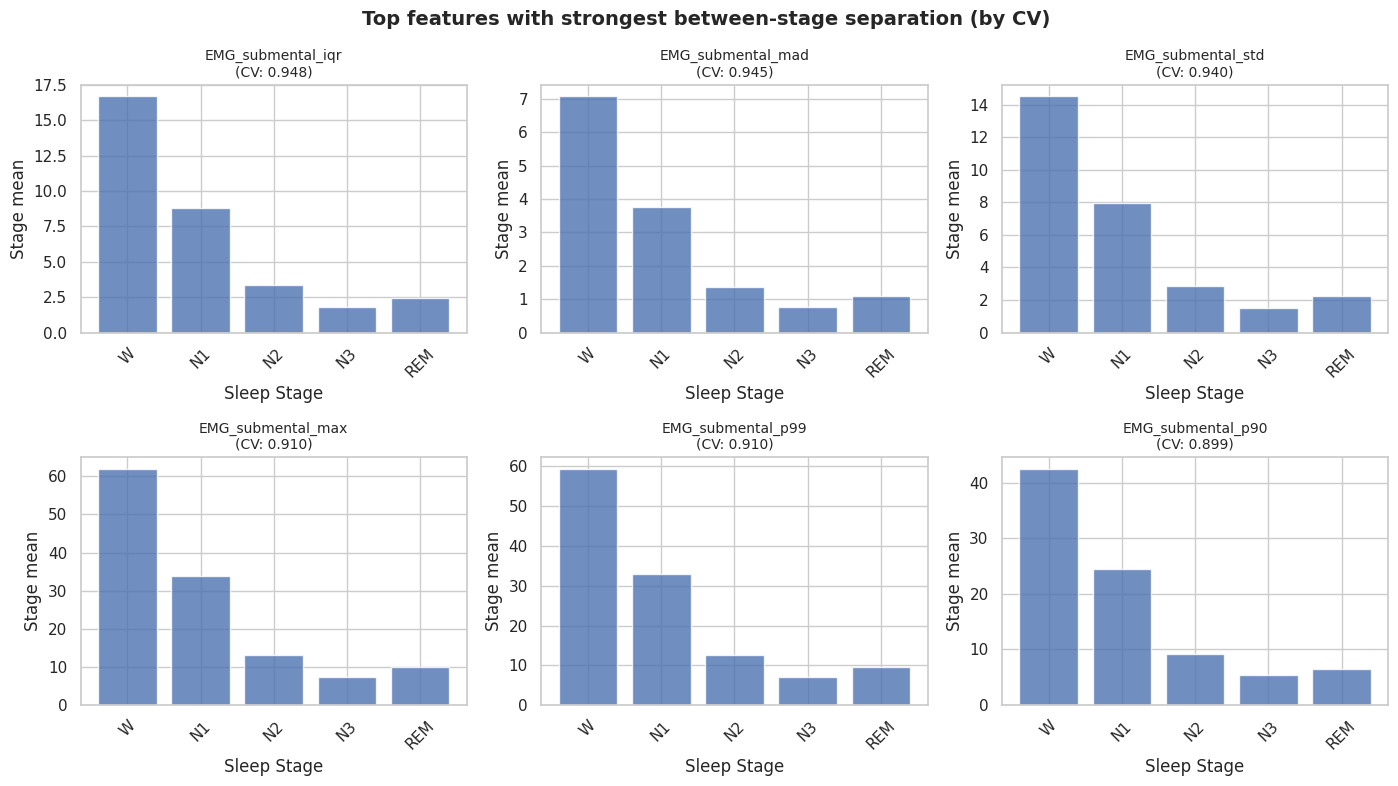


**How to read:**
- **High CV** suggests the feature’s **stage means differ a lot** (potentially discriminative).
- Always confirm with **distribution plots** (e.g., violin/box per stage); CV can be skewed by outliers.
- If a feature’s overall mean is near **zero**, CV can blow up or be undefined — we guard that with `NaN`.
- Consider repeating this scan for **other channel groups** (e.g., `_512`, EOG/EMG/Resp) by adjusting the `simple_name` cleaning or filtering `scan_features`.


In [ ]:
NON_FEATURES = {"subject_id", "night_id", "stage"} 
N_TOP_SCAN   = 20   
TOP_SHOW     = 10   
TOP_PLOT     = 6    

display(Markdown("## Features with Highest Stage-wise Variability"))
display(Markdown(
"""
We compute, **for each feature**, the mean value **per sleep stage** and then the
**Coefficient of Variation (CV)** across those stage-means:  
\\[
\\mathrm{CV} = \\frac{\\mathrm{std\\_across\\_stages}}{\\mathrm{mean\\_across\\_stages}}
\\]
Higher CV ⇒ stronger **between-stage separation** (rough heuristic).
"""
))

numeric_features = [col for col in df.columns if col not in NON_FEATURES]

scan_features = numeric_features[:N_TOP_SCAN]
stage_means = df.group_by("stage").agg([
    pl.col(feature).mean().alias(feature) for feature in scan_features
])

cv_scores = []
for feature in scan_features:
    means = stage_means.select(feature).to_pandas()[feature]
    m = means.mean()
    s = means.std()
    cv = (s / m) if (m != 0 and np.isfinite(m)) else np.nan
    cv_scores.append((feature, cv))

cv_scores = [(f, c) for (f, c) in cv_scores if pd.notna(c)]
cv_scores.sort(key=lambda x: x[1], reverse=True)

display(Markdown(f"### Top {min(TOP_SHOW, len(cv_scores))} features by stage-wise CV"))
rows = []
for rank, (feature, cv) in enumerate(cv_scores[:TOP_SHOW], 1):
    simple_name = (feature
                   .replace('EEG_Fpz_Cz_', '')
                   .replace('_256', '')
                   .replace('_512', '')
                   .replace('_1hz', ''))
    rows.append({"#": rank, "feature": feature, "simple_name": simple_name, "CV": cv})

top_df = pd.DataFrame(rows)
display(
    top_df.style
         .format({"CV": "{:.3f}"})
         .hide(axis="index")
         .set_caption("Coefficient of Variation computed over per-stage means")
)

if len(cv_scores) > 0:
    n_plot = min(TOP_PLOT, len(cv_scores))
    fig, axes = plt.subplots(2, int(np.ceil(n_plot/2)), figsize=(14, 8))
    axes = np.array(axes).reshape(-1)  # flatten
    for i, (feature, cv) in enumerate(cv_scores[:n_plot]):
        stage_data = df.group_by("stage").agg(pl.col(feature).mean()).to_pandas()
        stage_data = stage_data.set_index('stage').reindex(stage_order)

        simple_name = (feature
                       .replace('EEG_Fpz_Cz_', '')
                       .replace('_256', '')
                       .replace('_512', '')
                       .replace('_1hz', ''))
        ax = axes[i]
        ax.bar(stage_data.index, stage_data[feature], alpha=0.8)
        ax.set_title(f'{simple_name}\n(CV: {cv:.3f})', fontsize=10)
        ax.set_xlabel('Sleep Stage')
        ax.set_ylabel('Stage mean')
        ax.tick_params(axis='x', rotation=45)

    for j in range(n_plot, len(axes)):
        axes[j].axis('off')

    plt.suptitle('Top features with strongest between-stage separation (by CV)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    display(Markdown("> No valid CV scores (check if scanned features have non-zero means across stages)."))

display(Markdown(
"""
**How to read:**
- **High CV** suggests the feature’s **stage means differ a lot** (potentially discriminative).
- Always confirm with **distribution plots** (e.g., violin/box per stage); CV can be skewed by outliers.
- If a feature’s overall mean is near **zero**, CV can blow up or be undefined — we guard that with `NaN`.
- Consider repeating this scan for **other channel groups** (e.g., `_512`, EOG/EMG/Resp) by adjusting the `simple_name` cleaning or filtering `scan_features`.
"""
))

In [ ]:
stage_order = ["W","N1","N2","N3","REM"]

NON_FEATURES = {"subject_id","night_id","epoch_idx","t0_sec","stage"} 
EXTRA_DROP_FOR_RANK = {"tso_min"}        
ROBUST_EPS = 1e-8                    
TOP_SHOW = 15                            
TOP_PLOT = 6                      

display(Markdown("""
## Feature Ranking Across Sleep Stages — Composite Score

**Goal.** Find features that best separate sleep stages using multiple criteria:

1. **Robust CV across stage-means** — std/median(|centered stage-means|); less sensitive to scaling/outliers.
2. **Fisher score** — between-stage variance / within-stage variance (weighted by counts).
3. **Kruskal–Wallis η²** — nonparametric effect size across stages.
4. **Mutual Information (MI)** — feature ↔ stage association (model-free).

We **normalize** each criterion to [0,1] and compute a **composite score = mean(normalized criteria)**.
Higher → stronger stage discrimination.  
Finally, we show **Top-N** features and per-stage **bar plots** of their means.

**Reading tips.**
- Use this as a **first pass**; confirm with distributions (e.g., violin per stage) and cross-subject validation.
- If you later allow time proxies (e.g., `tso_min`), re-run and watch for **leakage**.
"""))

num_cols = [c for c in df.select(cs.numeric()).columns if c not in NON_FEATURES]
const_cols = [c for c in num_cols if df.select(pl.col(c).n_unique()).item() <= 1]
feat_cols = [c for c in num_cols if c not in const_cols and c not in EXTRA_DROP_FOR_RANK]

display(Markdown("### 1) Feature set after prefiltering"))
display(Markdown(
f"- **Numeric columns:** {len(num_cols)}  \n"
f"- **Removed constants:** {len(const_cols)}  \n"
f"- **Evaluated for ranking (excl. time proxies):** {len(feat_cols)}"
))

df_sub = df.select(["stage"] + feat_cols).drop_nulls()
pdf = df_sub.to_pandas()
pdf["stage"] = pd.Categorical(pdf["stage"], categories=stage_order, ordered=True)

agg_exprs = []
for f in feat_cols:
    agg_exprs += [
        pl.col(f).mean().alias(f"{f}__mean"),
        pl.col(f).std().alias(f"{f}__std"),
        pl.count().alias(f"{f}__n"),
    ]
stage_stats = (
    df_sub.group_by("stage")
          .agg(agg_exprs)
          .sort("stage")
          .to_pandas()
          .set_index("stage")
          .reindex(stage_order)
)

def stack_by_stage(prefix: str, stat_df: pd.DataFrame):
    cols = [f"{f}{prefix}" for f in feat_cols]
    return stat_df[cols].to_numpy(dtype=float)

means_mat = stack_by_stage("__mean", stage_stats) if feat_cols else np.empty((0,0))
stds_mat  = stack_by_stage("__std",  stage_stats) if feat_cols else np.empty((0,0))
n_vec = stage_stats[f"{feat_cols[0]}__n"].to_numpy(dtype=int) if feat_cols else np.array([], dtype=int)

cv_scores = []
for j, f in enumerate(feat_cols):
    mu_k = means_mat[:, j]                          
    mu_scale = np.median(np.abs(mu_k)) + ROBUST_EPS 
    cv = np.std(mu_k) / mu_scale
    cv_scores.append((f, float(cv)))

fisher_scores = []
for j, f in enumerate(feat_cols):
    mu_k = means_mat[:, j]                
    sig_k = stds_mat[:, j]                 
    mu = np.average(mu_k, weights=n_vec) if n_vec.size else mu_k.mean()
    num = np.sum(n_vec * (mu_k - mu)**2) if n_vec.size else np.sum((mu_k - mu)**2)  
    den = np.sum(n_vec * (sig_k**2)) if n_vec.size else np.sum(sig_k**2)          
    fisher = num / (den + ROBUST_EPS)
    fisher_scores.append((f, float(fisher)))

def kruskal_eta2_safe(frame: pd.DataFrame, feature: str, classes: list[str]) -> float:
    d = frame[["stage", feature]].dropna()
    groups = [d.loc[d["stage"] == s, feature].values for s in classes if (d["stage"] == s).sum() >= 2]
    if len(groups) < 2:
        return np.nan
    all_vals = np.concatenate(groups)
    if np.nanstd(all_vals) == 0:
        return 0.0
    try:
        H, _ = kruskal(*groups)
    except ValueError:
        return 0.0
    n = len(all_vals); k = len(groups)
    eta2 = (H - k + 1) / (n - k) if (n - k) > 0 else np.nan
    return float(eta2)

eta2_scores = [(f, kruskal_eta2_safe(pdf, f, stage_order)) for f in feat_cols]

use_mi = True
if use_mi and len(feat_cols) > 0:
    X = pdf[feat_cols].to_numpy()
    y = pdf["stage"].cat.codes.to_numpy()
    mi = mutual_info_classif(X, y, discrete_features=False, random_state=0)
    mi_scores = list(zip(feat_cols, [float(v) for v in mi]))
else:
    mi_scores = []

def normalize(series):
    arr = np.asarray(series, dtype=float)
    m, M = np.nanmin(arr), np.nanmax(arr)
    if not np.isfinite(m) or not np.isfinite(M) or abs(M - m) < 1e-12:
        return np.zeros_like(arr)
    return (arr - m) / (M - m)

df_rank = pd.DataFrame({
    "feature": feat_cols,
    "cv": [v for _, v in cv_scores],
    "fisher": [v for _, v in fisher_scores],
    "eta2": [v for _, v in eta2_scores],
})

if mi_scores:
    mi_map = dict(mi_scores)
    df_rank["mi"] = df_rank["feature"].map(mi_map)
else:
    df_rank["mi"] = np.nan

for col in ["cv","fisher","eta2","mi"]:
    df_rank[f"norm_{col}"] = normalize(df_rank[col].values)

available_norms = [c for c in ["norm_cv","norm_fisher","norm_eta2","norm_mi"] if c in df_rank.columns]
df_rank["score"] = np.nanmean(df_rank[available_norms].values, axis=1)

df_rank = df_rank.sort_values("score", ascending=False).reset_index(drop=True)

display(Markdown("### 2) Top features by composite score"))
with pd.option_context("display.max_rows", TOP_SHOW, "display.max_columns", None):
    display(
        df_rank.head(TOP_SHOW).style
            .format({"cv":"{:.3f}","fisher":"{:.3f}","eta2":"{:.3f}","mi":"{:.3f}","score":"{:.3f}"})
            .hide(axis="index")
            .set_caption("Scores are normalized to [0,1] per criterion and averaged.")
    )

top_feats = df_rank.head(TOP_PLOT)["feature"].tolist()

if top_feats:
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i, feature in enumerate(top_feats):
        stage_means_feat = (
            df_sub.group_by("stage")
                  .agg(pl.col(feature).mean().alias(feature))
                  .to_pandas()
                  .set_index("stage")
                  .reindex(stage_order)
        )
        simple_name = (
            feature.replace("EEG_Fpz_Cz_", "")
                   .replace("EEG_Pz_Oz_", "")
                   .replace("_256","").replace("_512","")
                   .replace("_1hz","")
        )
        score_val = float(df_rank.loc[df_rank["feature"]==feature,"score"].values[0])
        axes[i].bar(stage_means_feat.index, stage_means_feat[feature], alpha=0.75)
        axes[i].set_title(f"{simple_name}\n(score={score_val:.3f})", fontsize=10)
        axes[i].set_xlabel("Sleep Stage")
        axes[i].set_ylabel("Stage mean")
        axes[i].tick_params(axis='x', rotation=45)

    for j in range(len(top_feats), len(axes)):
        axes[j].axis('off')

    plt.suptitle('Top features with strongest between-stage separation (composite score)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    display(Markdown("> No features available to plot."))

display(Markdown("""
**Notes & next steps**
- **Composite score** helps reconcile different criteria; still, review **per-stage distributions** for the finalists.
- If you later include **TSO** (or other temporal proxies) in `feat_cols`, re-run and watch MI/η² spikes (leakage risk).
- Consider running the ranking by **channel family** (EEG/EOG/EMG/Resp/Temp) to ensure diversity among top features.
"""))


## Feature Ranking Across Sleep Stages — Composite Score

**Goal.** Find features that best separate sleep stages using multiple criteria:

1. **Robust CV across stage-means** — std/median(|centered stage-means|); less sensitive to scaling/outliers.
2. **Fisher score** — between-stage variance / within-stage variance (weighted by counts).
3. **Kruskal–Wallis η²** — nonparametric effect size across stages.
4. **Mutual Information (MI)** — feature ↔ stage association (model-free).

We **normalize** each criterion to [0,1] and compute a **composite score = mean(normalized criteria)**.
Higher → stronger stage discrimination.  
Finally, we show **Top-N** features and per-stage **bar plots** of their means.

**Reading tips.**
- Use this as a **first pass**; confirm with distributions (e.g., violin per stage) and cross-subject validation.
- If you later allow time proxies (e.g., `tso_min`), re-run and watch for **leakage**.


### 1) Feature set after prefiltering

- **Numeric columns:** 268  
- **Removed constants:** 4  
- **Evaluated for ranking (excl. time proxies):** 263

/tmp/ipykernel_611478/2179888685.py:48: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias(f"{f}__n"),


ValueError: Input X contains NaN.

## 7. Conclusions and Insights

### 7.1 Key Findings

In [ ]:
stage_order = ["W","N1","N2","N3","REM"]   
QUALITY_COLS = {
    "Respiration — clipping fraction": "Resp_oronasal_clip_frac_1hz",
    "Temperature — out-of-range fraction": "Temp_rectal_oor_frac_1hz",
}

total_epochs = int(df.height)
total_hours  = total_epochs / 120.0  
total_feats  = int(df.width)

try:
    null_df = df.null_count().to_pandas()
    total_nulls = int(null_df.sum(axis=1).iloc[0])
except Exception:
    total_nulls = int(df.select([pl.col(c).is_null().sum().alias(c) for c in df.columns]).to_pandas().sum(axis=1).iloc[0])

missing_pct = 100.0 * total_nulls / (total_epochs * total_feats) if total_feats > 0 and total_epochs > 0 else 0.0
quality_msg = "100% complete (no missing values)" if total_nulls == 0 else f"{missing_pct:.2f}% cells missing"

display(Markdown("## Exploratory Analysis — Summary"))
display(Markdown(
f"""
**General data**
- **Total epochs:** {total_epochs:,} (≈ **{total_hours:.1f} h**)
- **Available features (columns):** {total_feats}
- **Completeness:** {quality_msg}
"""
))

try:
    cls_counts_pd = cls_counts.to_pandas().copy()
    if "proportion" not in cls_counts_pd.columns:
        total = cls_counts_pd["count"].sum()
        cls_counts_pd["proportion"] = cls_counts_pd["count"] / total
except NameError:
    counts = (
        df.group_by("stage")
          .agg(pl.len().alias("count"))
          .to_pandas()
    )
    total = int(counts["count"].sum())
    counts["proportion"] = counts["count"] / total if total > 0 else 0.0
    cls_counts_pd = counts

if set(stage_order).issuperset(set(cls_counts_pd["stage"].unique())):
    cls_counts_pd["stage"] = pd.Categorical(cls_counts_pd["stage"], categories=stage_order, ordered=True)
    cls_counts_pd = cls_counts_pd.sort_values("stage")

display(Markdown("### Sleep stage distribution"))
display(
    cls_counts_pd.style
        .format({"proportion": "{:.1%}", "count": "{:,}"})
        .hide(axis="index")
        .set_caption("Per-stage proportion and epoch counts")
)

quality_rows = []
for nice_name, col in QUALITY_COLS.items():
    if col in df.columns:
        stats = df.select([
            pl.col(col).mean().alias("mean"),
            (pl.col(col) > 0).sum().alias("affected"),
            (pl.col(col) > 0.2).sum().alias("high"),
            pl.len().alias("N"),
        ]).to_pandas().iloc[0]
        affected_pct = 100.0 * stats["affected"] / stats["N"]
        high_pct     = 100.0 * stats["high"] / stats["N"]
        quality_rows.append({
            "metric": nice_name,
            "feature": col,
            "mean": stats["mean"],
            "affected_epochs (>0)": int(stats["affected"]),
            "affected_%": affected_pct,
            "high_epochs (>0.2)": int(stats["high"]),
            "high_%": high_pct
        })

if quality_rows:
    qdf = pd.DataFrame(quality_rows)
    display(Markdown("### Signal quality — quick audit"))
    display(
        qdf.style
           .format({"mean": "{:.4f}", "affected_%": "{:.1f}%", "high_%": "{:.1f}%"})
           .hide(axis="index")
           .set_caption("Fractions: 0–1 (per epoch). Use as QC flags or sample weights.")
    )

display(Markdown("### Key physiological/spectral insights"))
display(Markdown(
"""
- **EEG** shows distinct spectral patterns by stage.  
  - **Delta** dominates in **N3** (deep sleep).  
  - **Sigma** (spindles) is characteristic of **N2**.  
  - **Beta** is higher during **Wake (W)**.  
- **EOG** exhibits stage-specific patterns, with rapid eye movements in **REM**.  
- **EMG** (submental) tends to decrease from **W → REM** (muscle atonia).
"""
))

display(Markdown("### Modeling recommendations"))
display(Markdown(
"""
- Prioritize **relative power (relpow)** features and **band ratios** (e.g., slow/fast).
- Include **global spectral summaries** (SEF95, median frequency, spectral entropy, aperiodic slope).
- **Temporal context** helps: if you use `tso_min`, audit for **causality** (avoid label leakage); consider a **causal proxy**.
- Treat **quality flags** (clipping / out-of-range) as **weights** or **QC features** to reduce overfitting to noisy epochs.
- Compare **both Welch settings** (`_256` and `_512`); ablate later to simplify.
"""
))

display(Markdown(
"> **TL;DR:** data volume is solid, stage balance is clear, EEG/EOG/EMG behave physiologically, "
"and QC flags are informative — you’re good to proceed to feature ranking and baseline models."
))

## Exploratory Analysis — Summary


**General data**
- **Total epochs:** 2,650 (≈ **22.1 h**)
- **Available features (columns):** 250
- **Completeness:** 100% complete (no missing values)


### Sleep stage distribution

stage,count,proportion
W,"1,997",75.4%
N1,58,2.2%
N2,250,9.4%
N3,220,8.3%
REM,125,4.7%


### Signal quality — quick audit

metric,feature,mean,affected_epochs (>0),affected_%,high_epochs (>0.2),high_%
Respiration — clipping fraction,Resp_oronasal_clip_frac_1hz,0.0032,70,2.6%,10,0.4%
Temperature — out-of-range fraction,Temp_rectal_oor_frac_1hz,0.0000,0,0.0%,0,0.0%


### Key physiological/spectral insights


- **EEG** shows distinct spectral patterns by stage.  
  - **Delta** dominates in **N3** (deep sleep).  
  - **Sigma** (spindles) is characteristic of **N2**.  
  - **Beta** is higher during **Wake (W)**.  
- **EOG** exhibits stage-specific patterns, with rapid eye movements in **REM**.  
- **EMG** (submental) tends to decrease from **W → REM** (muscle atonia).


### Modeling recommendations


- Prioritize **relative power (relpow)** features and **band ratios** (e.g., slow/fast).
- Include **global spectral summaries** (SEF95, median frequency, spectral entropy, aperiodic slope).
- **Temporal context** helps: if you use `tso_min`, audit for **causality** (avoid label leakage); consider a **causal proxy**.
- Treat **quality flags** (clipping / out-of-range) as **weights** or **QC features** to reduce overfitting to noisy epochs.
- Compare **both Welch settings** (`_256` and `_512`); ablate later to simplify.


> **TL;DR:** data volume is solid, stage balance is clear, EEG/EOG/EMG behave physiologically, and QC flags are informative — you’re good to proceed to feature ranking and baseline models.

### 8.2 Próximos Passos

Com base nesta análise exploratória, os próximos passos recomendados são:

1. **Seleção de Features**: Priorizar features com alta variabilidade entre estágios
2. **Engenharia de Features**: Criar ratios e combinações das bandas espectrais
3. **Tratamento de Artefatos**: Implementar pesos baseados nas métricas de qualidade
4. **Validação Temporal**: Considerar a sequência temporal dos estágios
5. **Modelagem**: Testar diferentes algoritmos considerando o desbalanceamento das classes

---

*Este notebook fornece uma base sólida para o desenvolvimento de modelos de classificação de estágios do sono, com insights claros sobre a natureza e qualidade dos dados disponíveis.*